In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO, SeqUtils
import numpy as np
import os
import subprocess
from pathlib import Path
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'

Loading BokehJS ...

## Genome level stats

In [3]:
thermo = list(SeqIO.parse("data/thermo/gb/Thermus_thermophilus_hb27_gca_000008125.ASM812v1.53.chromosome.Chromosome.dat", "genbank").records)[0]
ecoli = list(SeqIO.parse("data/thermo/ecoli_dh5.gb", "genbank").records)[0]
alex_cds = "ATGAGCAAAGGAGAAGAACTTTTCACTGGAGTTGTCCCAATTCTTGTTGAATTAGATGGTGATGTTAATGGGCACAAATTTTCTGTCCGTGGAGAGGGTGAAGGTGATGCTACAAACGGAAAACTCACCCTTAAATTTATTTGCACTACTGGAAAACTACCTGTTCCGTGGCCAACACTTGTCACTACTCTGACCTATGGTCTTATGTGCTTTTCCCGTTATCCGGATCACATGAAACGGCATGACTTTTTCAAGAGTGCCATGCCCGAAGGTTATGTACAGGAACGCACTATATCTTTCAAAGATGACGGGACCTACAAGACGCGTGCTGAAGTCAAGTTTGAAGGTGATACCCTTGTTAATCGTATCGAGTTAAAGGGTATTGATTTTAAAGAAGATGGAAACATTCTTGGACACAAACTCGAGTACAACTTTAACTCACACAATGTATACATCACGGCAGACAAACAAAAGAATGGAATCAAAGCTAACTTCAAAATTCGCCACAACGTTGAAGATGGTTCCGTTCAACTAGCAGACCATTATCAACAAAATACTCCAATTGGCGATGGCCCTGTCCTTTTACCAGACAACCATTACCTGTCGACACAATCTGTCCTTTCGAAAGATCCCAACGAAAAGCGTGACCACATGGTCCTTCTTGAGTTTGTAACTGCTGCTGGGATTACACATGGCATGGATGAGCTCTACAAATAATAA"

In [4]:
thermo_df = pd.read_parquet("data/thermo/allres_thermo_tpm.pq").dropna()
ecoli_df = pd.read_parquet("data/thermo/allres_ecoli_tpm.pq").dropna()
alex_df = pd.read_parquet("data/thermo/ares_tpm.pq")
alex_df['no'] = alex_df.no.astype('str')
alex_df['cat'] = "ARES"
ecoli_df['cat'] = "E. coli"
thermo_df['cat'] = "T. thermophilus"

In [5]:
eperc = ecoli_df.TPM.describe(percentiles=[0.5,0.9])
tperc = thermo_df.TPM.describe(percentiles=[0.5,0.9])
aperc = alex_df.describe(percentiles=[0.5,0.9])

In [6]:
ecoli_df.loc[ecoli_df['TPM']>=eperc['90%'],'bucket'] = 'high'
ecoli_df.loc[(ecoli_df['TPM']<eperc['90%']) & (ecoli_df['TPM']>=eperc['50%']) ,'bucket'] = 'medium'
ecoli_df.loc[ecoli_df['TPM']<eperc['50%'],'bucket'] = 'low'
thermo_df.loc[thermo_df['TPM']>=tperc['90%'],'bucket'] = 'high'
thermo_df.loc[(thermo_df['TPM']<tperc['90%']) & (thermo_df['TPM']>=tperc['50%']) ,'bucket'] = 'medium'
thermo_df.loc[thermo_df['TPM']<tperc['50%'],'bucket'] = 'low'
alex_df.loc[alex_df['thermo']>=aperc['thermo']['90%'],'thermo_bucket'] = 'high'
alex_df.loc[(alex_df['thermo']<aperc['thermo']['90%']) & (alex_df['thermo']>=aperc['thermo']['50%']) ,'thermo_bucket'] = 'medium'
alex_df.loc[alex_df['thermo']<aperc['thermo']['50%'],'thermo_bucket'] = 'low'
alex_df.loc[alex_df['ecoli']>=aperc['ecoli']['90%'],'ecoli_bucket'] = 'high'
alex_df.loc[(alex_df['ecoli']<aperc['ecoli']['90%']) & (alex_df['ecoli']>=aperc['ecoli']['50%']) ,'ecoli_bucket'] = 'medium'
alex_df.loc[alex_df['ecoli']<aperc['ecoli']['50%'],'ecoli_bucket'] = 'low'

In [7]:
thermo_df.shape,ecoli_df.shape

((1969, 18), (4205, 19))

In [6]:
thermo_df.to_parquet("data/thermo/allres_thermo_tpm.pq")
ecoli_df.to_parquet("data/thermo/allres_ecoli_tpm.pq")
alex_df.to_parquet("data/thermo/ares_tpm.pq")

In [13]:
thermo_cds = "".join(thermo_df.cds.values)
ecoli_cds = "".join(ecoli_df.cds.values)
thermo_res = "".join(thermo_df.res.values)
ecoli_res = "".join(ecoli_df.res.values)

In [8]:
print(f"Thermo Genome size: {len(thermo.seq)} bp")
print(f"Ecoli DH5 alpha Genome size: {len(ecoli.seq)} bp")

Thermo Genome size: 1894877 bp
Ecoli DH5 alpha Genome size: 4490755 bp


In [9]:
print(f"Thermo GC for whole genome: {SeqUtils.GC(thermo.seq):.2f}%")
print(f"Ecoli DH5 alpha GC for whole genome: {SeqUtils.GC(ecoli.seq):.2f}%")

Thermo GC for whole genome: 69.44%
Ecoli DH5 alpha GC for whole genome: 50.74%


In [10]:
print(f"Thermo CDS size: {len(thermo_cds)} bp")
print(f"Ecoli DH5 alpha CDS size: {len(ecoli_cds)} bp")

Thermo CDS size: 1793391 bp
Ecoli DH5 alpha CDS size: 3961399 bp


In [14]:
print(f"Thermo GC for all CDSs: {SeqUtils.GC(thermo_cds):.2f}%")
print(f"Ecoli DH5 alpha GC for all CDSs: {SeqUtils.GC(ecoli_cds):.2f}%")
print(f"GC for IFP CDS: {SeqUtils.GC(alex_cds):.2f}%")
print(f"Thermo GC for all RESs: {SeqUtils.GC(thermo_res):.2f}%")
print(f"Ecoli DH5 alpha GC for all RESs: {SeqUtils.GC(ecoli_res):.2f}%")

Thermo GC for all CDSs: 69.59%
Ecoli DH5 alpha GC for all CDSs: 51.80%
GC for IFP CDS: 41.94%
Thermo GC for all RESs: 68.76%
Ecoli DH5 alpha GC for all RESs: 47.35%


In [12]:
thermo_df['res_gc'] = thermo_df.res.apply(lambda x: SeqUtils.GC(x))
thermo_df['cds_gc'] = thermo_df.cds.apply(lambda x: SeqUtils.GC(x))
ecoli_df['res_gc'] = ecoli_df.res.apply(lambda x: SeqUtils.GC(x))
ecoli_df['cds_gc'] = ecoli_df.cds.apply(lambda x: SeqUtils.GC(x))
alex_df['res_gc'] = alex_df.seq.apply(lambda x: SeqUtils.GC(x))

In [445]:
thermo_df.groupby("bucket")["TPM"].describe()

,count,mean,std,min,25%,50%,75%,max
bucket,,,,,,,,
high,197.0,2995.779374,4844.812841,732.665809,951.988848,1455.079185,2665.963177,39537.687834
low,984.0,84.867732,44.136935,1.638445,48.355217,83.826936,124.608401,163.744702
medium,788.0,314.220636,132.754183,163.746254,206.427128,272.421726,381.847671,729.553988


In [87]:
ecoli_df.groupby("bucket")["TPM"].describe()

,count,mean,std,min,25%,50%,75%,max
bucket,,,,,,,,
high,421.0,889.350419,1898.113966,360.569644,398.001168,458.831731,640.452012,19854.640599
low,2102.0,92.175394,36.928855,0.000000,62.636898,94.048208,123.858521,153.921586
medium,1682.0,226.418928,54.605554,153.944622,179.333992,215.001691,264.113786,360.421020


In [88]:
alex_df.groupby("thermo_bucket")["thermo"].describe()

,count,mean,std,min,25%,50%,75%,max
thermo_bucket,,,,,,,,
high,6.0,59768.063959,18136.772384,36051.261369,52195.089797,54209.362823,70890.986311,86163.203810
low,27.0,4936.608827,1491.593238,2320.203090,3880.644981,5122.249495,5995.727683,7684.867781
medium,22.0,15001.107564,5568.220089,8239.074447,10549.812236,14580.522399,17670.443320,30413.664815


In [89]:
alex_df.groupby("ecoli_bucket")["ecoli"].describe()

,count,mean,std,min,25%,50%,75%,max
ecoli_bucket,,,,,,,,
high,6.0,59657.175020,25370.659928,32860.263737,39742.534091,55319.046077,75679.160808,97428.465084
low,27.0,1190.649500,638.300299,239.113349,635.806300,1144.281536,1682.548280,2212.911912
medium,22.0,10006.371941,10036.241784,2367.645751,2724.737825,4749.921069,13285.418523,32527.347427


In [90]:
thermo_df.describe()

,strand,Length,EffectiveLength,TPM,NumReads,res_gc,cds_gc,intergen_len
count,1969.000000,1969.000000,1969.000000,1969.000000,1.969000e+03,1969.000000,1969.000000,1969.000000
mean,-0.102082,910.813103,477.910064,467.894488,2.151251e+04,68.215389,69.365169,67.212291
std,0.995029,552.210901,452.912408,1751.622259,6.474871e+04,4.920450,3.254937,187.557513
min,-1.000000,123.000000,4.000000,1.638445,5.900000e+01,43.000000,45.794393,0.000000
25%,-1.000000,513.000000,251.000000,83.839147,5.387000e+03,65.882353,67.577413,0.000000
50%,-1.000000,795.000000,265.988667,163.746254,1.130800e+04,69.000000,69.620253,14.000000
75%,1.000000,1173.000000,574.117333,322.204860,2.279500e+04,71.274510,71.523179,63.000000
max,1.000000,5403.000000,4737.117333,39537.687834,2.355083e+06,82.000000,77.349398,3276.000000


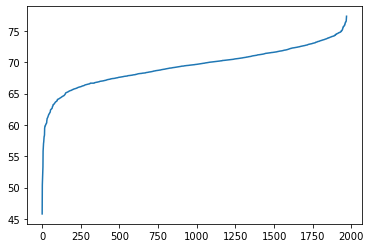

In [91]:
plt.plot(sorted(thermo_df.cds_gc))

In [408]:
ecoli_df.describe()

,strand,Length,EffectiveLength,TPM,NumReads,res_gc,cds_gc,intergen_len
count,4205.000000,4205.000000,4205.000000,4205.000000,4205.000000,4205.000000,4205.000000,4205.000000
mean,0.013080,942.068728,450.503632,225.685099,172.903596,47.216300,50.984420,140.791914
std,1.000033,618.832843,364.220704,644.077132,137.161004,6.848278,5.031624,168.215804
min,-1.000000,120.000000,10.333333,0.000000,0.000000,22.000000,24.113475,0.000000
25%,-1.000000,495.000000,201.809667,94.082196,120.666667,43.000000,48.999310,11.000000
50%,1.000000,825.000000,353.315333,153.944622,153.333333,48.000000,52.008032,96.000000
75%,1.000000,1227.000000,579.333333,237.896565,199.666667,52.000000,54.081633,209.000000
max,1.000000,5422.000000,3797.412000,19854.640599,6198.855000,69.000000,68.707483,2285.000000


In [13]:
all_hdf = pd.concat([alex_df.loc[:,["cat","res_gc"]],ecoli_df.query("bucket=='high'").loc[:,["cat","res_gc"]],thermo_df.query("bucket=='high'").loc[:,["cat","res_gc"]]])

In [75]:
thermo_df['TPM'].shape,thermo_df['TPM'].dropna().shape

((1973,), (1969,))

In [93]:
thermo_df.TPM.describe()

count     1969.000000
mean       467.894488
std       1751.622259
min          1.638445
25%         83.839147
50%        163.746254
75%        322.204860
max      39537.687834
Name: TPM, dtype: float64

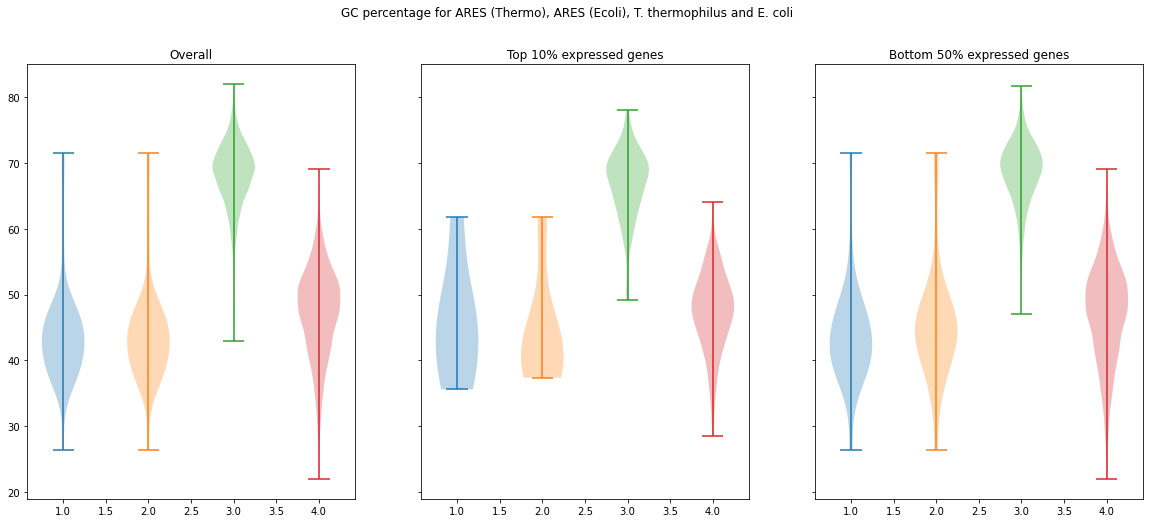

In [129]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(20,8))
fig.suptitle('GC percentage for ARES (Thermo), ARES (Ecoli), T. thermophilus and E. coli')
ax1.violinplot(alex_df['res_gc'], positions=[1])
ax1.violinplot(alex_df['res_gc'], positions=[2])
ax1.violinplot(thermo_df['res_gc'], positions=[3])
ax1.violinplot(ecoli_df['res_gc'], positions=[4])
ax1.set_title("Overall")
ax2.violinplot(alex_df.query("thermo_bucket=='high'")['res_gc'], positions=[1])
ax2.violinplot(alex_df.query("ecoli_bucket=='high'")['res_gc'], positions=[2])
ax2.violinplot(thermo_df.query("bucket=='high'")['res_gc'], positions=[3])
ax2.violinplot(ecoli_df.query("bucket=='high'")['res_gc'], positions=[4])
ax2.set_title("Top 10% expressed genes")
ax3.violinplot(alex_df.query("thermo_bucket=='low'")['res_gc'], positions=[1])
ax3.violinplot(alex_df.query("ecoli_bucket=='low'")['res_gc'], positions=[2])
ax3.violinplot(thermo_df.query("bucket=='low'")['res_gc'], positions=[3])
ax3.violinplot(ecoli_df.query("bucket=='low'")['res_gc'], positions=[4])
ax3.set_title("Bottom 50% expressed genes");
plt.savefig("gc_thermo.svg", format="svg")

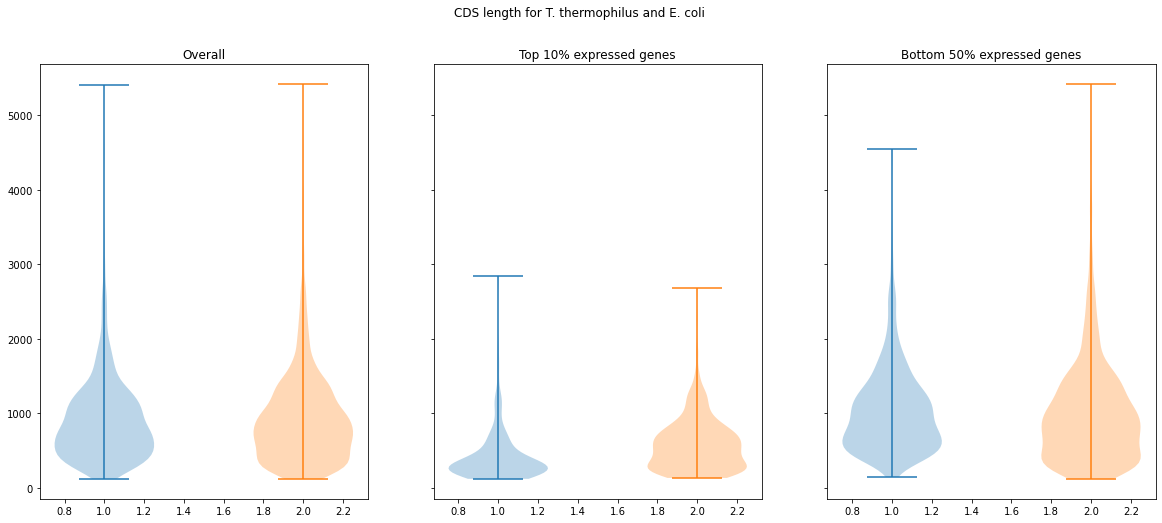

In [130]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(20,8))
fig.suptitle('CDS length for T. thermophilus and E. coli')
ax1.violinplot(thermo_df['cds'].str.len(), positions=[1])
ax1.violinplot(ecoli_df['cds'].str.len(), positions=[2])
ax1.set_title("Overall")
ax2.violinplot(thermo_df.query("bucket=='high'")['cds'].str.len(), positions=[1])
ax2.violinplot(ecoli_df.query("bucket=='high'")['cds'].str.len(), positions=[2])
ax2.set_title("Top 10% expressed genes")
ax3.violinplot(thermo_df.query("bucket=='low'")['cds'].str.len(), positions=[1])
ax3.violinplot(ecoli_df.query("bucket=='low'")['cds'].str.len(), positions=[2])
ax3.set_title("Bottom 50% expressed genes");
plt.savefig("cds_thermo.svg", format="svg")

In [138]:
thermo_df1 = pd.read_parquet("data/thermo/gb/Thermus_thermophilus_hb27_gca_000008125.ASM812v1.53.chromosome.Chromosome_mres1.pq")
ecoli_df1 = pd.read_parquet("data/thermo/ecoli_dh5_mres1.pq")

In [139]:
qtdf = thermo_df.TPM.to_frame()
qedf = ecoli_df.TPM.to_frame()
thermo_df1 = thermo_df1.join(qtdf)
ecoli_df1 = ecoli_df1.join(qedf)

In [142]:
ecoli_df1.loc[ecoli_df1['TPM']>=eperc['90%'],'bucket'] = 'high'
ecoli_df1.loc[(ecoli_df1['TPM']<eperc['90%']) & (ecoli_df1['TPM']>=eperc['50%']) ,'bucket'] = 'medium'
ecoli_df1.loc[ecoli_df1['TPM']<eperc['50%'],'bucket'] = 'low'
thermo_df1.loc[thermo_df1['TPM']>=tperc['90%'],'bucket'] = 'high'
thermo_df1.loc[(thermo_df1['TPM']<tperc['90%']) & (thermo_df1['TPM']>=tperc['50%']) ,'bucket'] = 'medium'
thermo_df1.loc[thermo_df1['TPM']<tperc['50%'],'bucket'] = 'low'

In [150]:
alex_df['seq_len'] = alex_df.seq.str.len()
alex_df.seq_len.describe()

count     55.000000
mean     184.909091
std       59.194054
min       34.000000
25%      197.000000
50%      203.000000
75%      203.000000
max      446.000000
Name: seq_len, dtype: float64

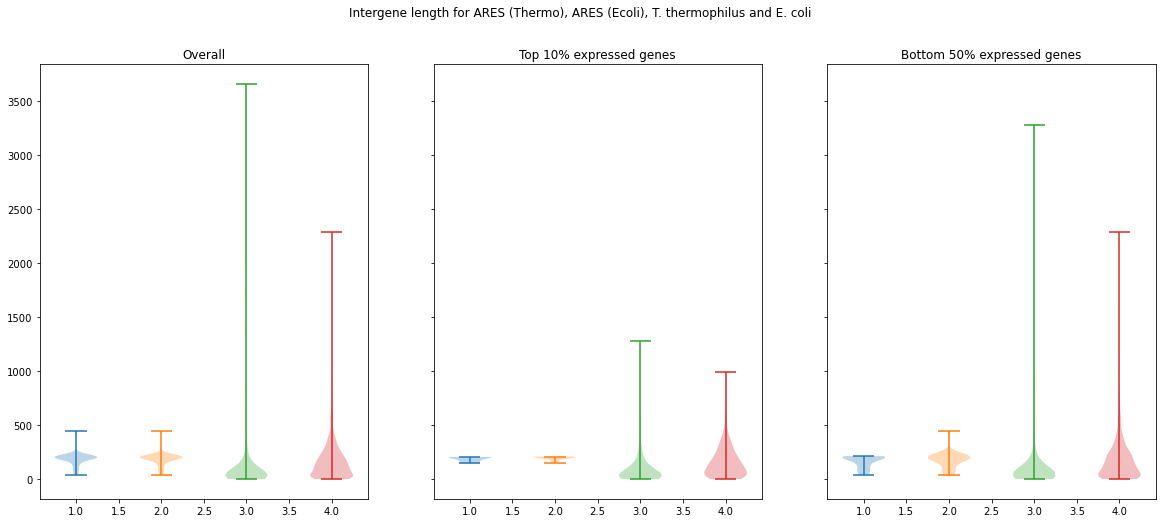

In [151]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(20,8))
fig.suptitle('Intergene length for ARES (Thermo), ARES (Ecoli), T. thermophilus and E. coli')
ax1.violinplot(alex_df['seq'].str.len(), positions=[1])
ax1.violinplot(alex_df['seq'].str.len(), positions=[2])
ax1.violinplot(thermo_df1['res'].str.len(), positions=[3])
ax1.violinplot(ecoli_df1['res'].str.len(), positions=[4])
ax1.set_title("Overall")
ax2.violinplot(alex_df.query("thermo_bucket=='high'")['seq'].str.len(), positions=[1])
ax2.violinplot(alex_df.query("ecoli_bucket=='high'")['seq'].str.len(), positions=[2])
ax2.violinplot(thermo_df1.query("bucket=='high'")['res'].str.len(), positions=[3])
ax2.violinplot(ecoli_df1.query("bucket=='high'")['res'].str.len(), positions=[4])
ax2.set_title("Top 10% expressed genes")
ax3.violinplot(alex_df.query("thermo_bucket=='low'")['seq'].str.len(), positions=[1])
ax3.violinplot(alex_df.query("ecoli_bucket=='low'")['seq'].str.len(), positions=[2])
ax3.violinplot(thermo_df1.query("bucket=='low'")['res'].str.len(), positions=[3])
ax3.violinplot(ecoli_df1.query("bucket=='low'")['res'].str.len(), positions=[4])
ax3.set_title("Bottom 50% expressed genes");
plt.savefig("intergene_thermo_sharey.svg", format="svg")

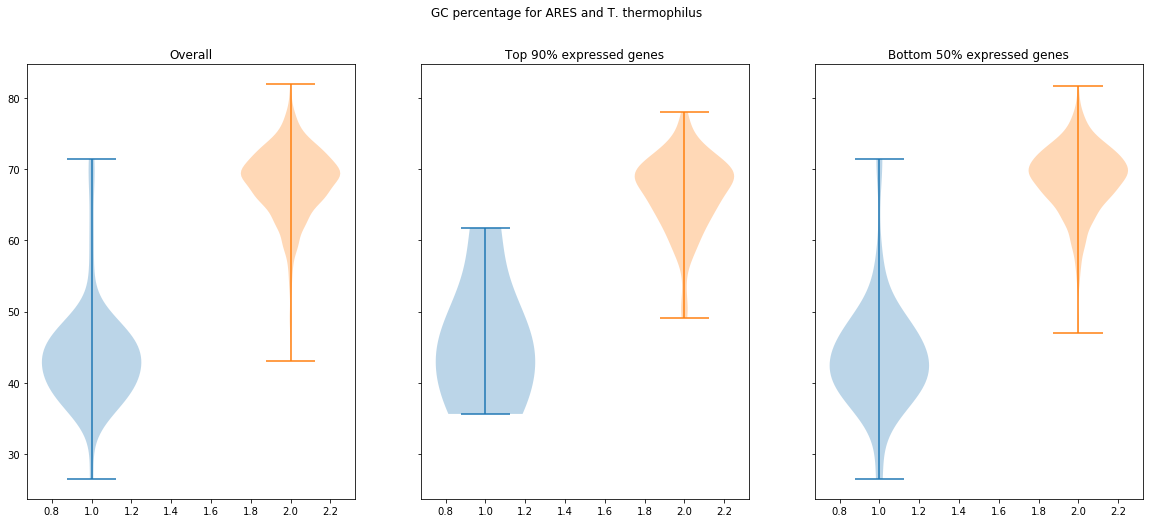

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(20,8))
fig.suptitle('GC percentage for ARES and T. thermophilus')
ax1.violinplot(alex_df['res_gc'], positions=[1])
ax1.violinplot(thermo_df['res_gc'], positions=[2])
ax1.set_title("Overall")
ax2.violinplot(alex_df.query("thermo_bucket=='high'")['res_gc'], positions=[1])
ax2.violinplot(thermo_df.query("bucket=='high'")['res_gc'], positions=[2])
ax2.set_title("Top 90% expressed genes")
ax3.violinplot(alex_df.query("thermo_bucket=='low'")['res_gc'], positions=[1])
ax3.violinplot(thermo_df.query("bucket=='low'")['res_gc'], positions=[2])
ax3.set_title("Bottom 50% expressed genes");
plt.savefig("gc_thermo_top90_bot50.svg", format="svg")

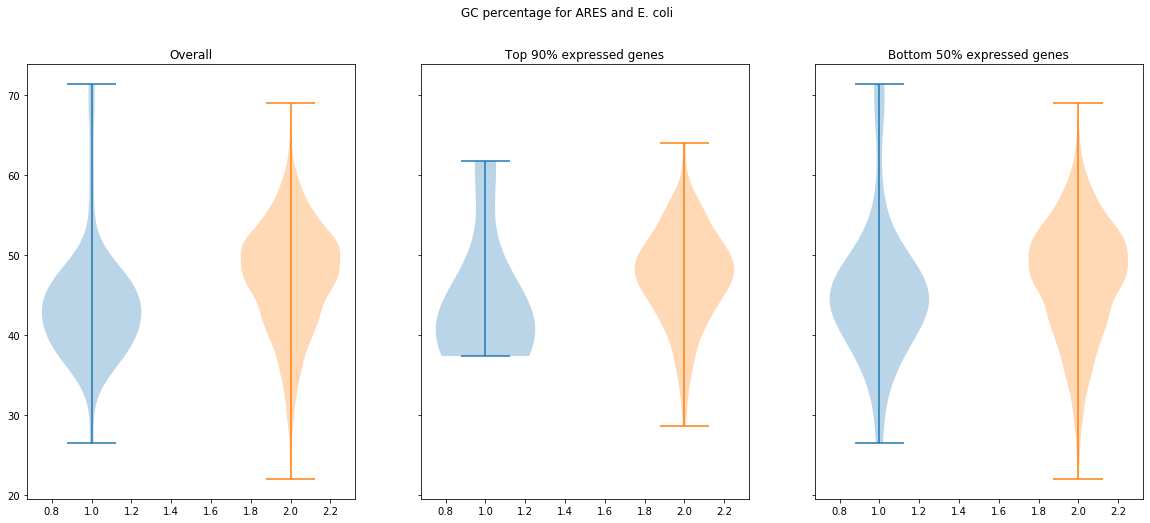

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(20,8))
fig.suptitle('GC percentage for ARES and E. coli')
ax1.violinplot(alex_df['res_gc'], positions=[1])
ax1.violinplot(ecoli_df['res_gc'], positions=[2])
ax1.set_title("Overall")
ax2.violinplot(alex_df.query("ecoli_bucket=='high'")['res_gc'], positions=[1])
ax2.violinplot(ecoli_df.query("bucket=='high'")['res_gc'], positions=[2])
ax2.set_title("Top 90% expressed genes")
ax3.violinplot(alex_df.query("ecoli_bucket=='low'")['res_gc'], positions=[1])
ax3.violinplot(ecoli_df.query("bucket=='low'")['res_gc'], positions=[2])
ax3.set_title("Bottom 50% expressed genes");
plt.savefig("gc_thermo_top90_bot50_ecoli.svg", format="svg")

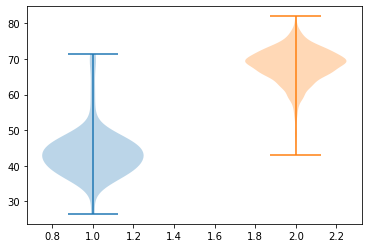

In [95]:
plt.violinplot(alex_df['res_gc'], positions=[1]);
plt.violinplot(thermo_df['res_gc'], positions=[2]);

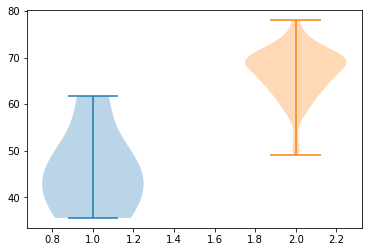

In [97]:
plt.violinplot(alex_df.query("thermo_bucket=='high'")['res_gc'], positions=[1]);
plt.violinplot(thermo_df.query("bucket=='high'")['res_gc'], positions=[2]);

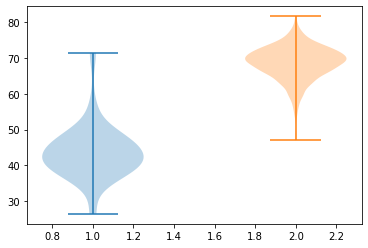

In [98]:
plt.violinplot(alex_df.query("thermo_bucket=='low'")['res_gc'], positions=[1]);
plt.violinplot(thermo_df.query("bucket=='low'")['res_gc'], positions=[2]);

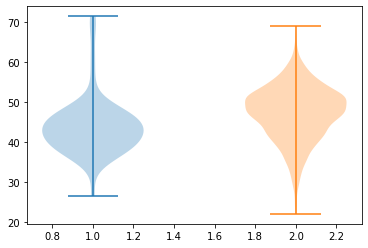

In [101]:
plt.violinplot(alex_df['res_gc'], positions=[1]);
plt.violinplot(ecoli_df['res_gc'], positions=[2]);

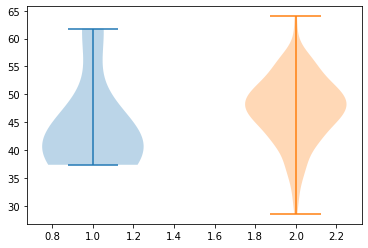

In [102]:
plt.violinplot(alex_df.query("ecoli_bucket=='high'")['res_gc'], positions=[1]);
plt.violinplot(ecoli_df.query("bucket=='high'")['res_gc'], positions=[2]);

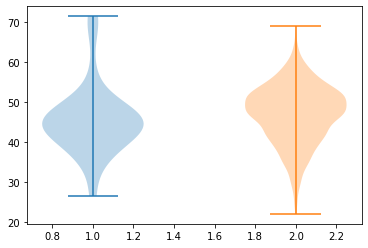

In [103]:
plt.violinplot(alex_df.query("ecoli_bucket=='low'")['res_gc'], positions=[1]);
plt.violinplot(ecoli_df.query("bucket=='low'")['res_gc'], positions=[2]);

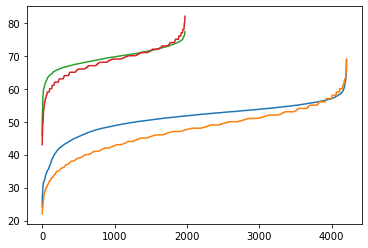

In [158]:
plt.plot(sorted(ecoli_df.cds_gc))
plt.plot(sorted(ecoli_df.res_gc))
plt.plot(sorted(thermo_df.cds_gc))
plt.plot(sorted(thermo_df.res_gc))

In [92]:
k, w = 30, 10
thermo_df['res_sliding_gc_30'] = thermo_df.res.apply(lambda x: [SeqUtils.GC(x[i:i+k]) for i in range(len(x)-k+1)])
ecoli_df['res_sliding_gc_30'] = ecoli_df.res.apply(lambda x: [SeqUtils.GC(x[i:i+k]) for i in range(len(x)-k+1)])
thermo_df['res_window_gc_10'] = thermo_df.res.apply(lambda x: [SeqUtils.GC(x[0:i+w]) for i in range(0,len(x),w)])
ecoli_df['res_window_gc_10'] = ecoli_df.res.apply(lambda x: [SeqUtils.GC(x[0:i+w]) for i in range(0,len(x),w)])

In [159]:
thermo_df.loc[:,['res_sliding_gc_30','res_window_gc_10']].head()

,res_sliding_gc_30,res_window_gc_10
Name,,
AAS80350,"[60.0, 60.0, 60.0, 60.0, 63.333333333333336, 6...","[70.0, 65.0, 60.0, 65.0, 68.0, 70.0, 70.0, 70...."
AAS80352,"[86.66666666666667, 90.0, 90.0, 86.66666666666...","[80.0, 85.0, 86.66666666666667, 85.0, 80.0, 80..."
AAS80353,"[80.0, 80.0, 76.66666666666667, 73.33333333333...","[80.0, 80.0, 80.0, 75.0, 72.0, 73.333333333333..."
AAS80354,"[66.66666666666667, 66.66666666666667, 66.6666...","[70.0, 65.0, 66.66666666666667, 62.5, 64.0, 60..."
AAS80355,"[73.33333333333333, 73.33333333333333, 73.3333...","[60.0, 70.0, 73.33333333333333, 72.5, 70.0, 70..."


In [135]:
tdf['intergen_len'] = tdf.res.str.len()
etdf['intergen_len'] = etdf.res.str.len()

In [139]:
itdf = tdf.intergen_len.to_frame()
ietdf = etdf.intergen_len.to_frame()

In [142]:
thermo_df = thermo_df.join(itdf)
ecoli_df = ecoli_df.join(ietdf)

In [145]:
thermo_df.intergen_len.fillna(0, inplace=True)
ecoli_df.intergen_len.fillna(0, inplace=True)

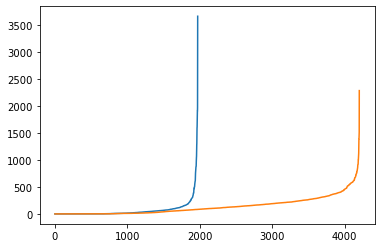

In [154]:
plt.plot(sorted(thermo_df.intergen_len))
plt.plot(sorted(ecoli_df.intergen_len))

In [127]:
tdf = pd.read_parquet("data/thermo/gb/Thermus_thermophilus_hb27_gca_000008125.ASM812v1.53.chromosome.Chromosome.pq")
etdf = pd.read_parquet("data/thermo/ecoli_dh5.pq")
tdf.shape, etdf.shape

((1374, 8), (3645, 9))

In [134]:
tdf.to_parquet("data/thermo/gb/Thermus_thermophilus_hb27_gca_000008125.ASM812v1.53.chromosome.Chromosome_mres1.pq")
etdf.to_parquet("data/thermo/ecoli_dh5_mres1.pq")
tdf.shape, etdf.shape

((1374, 7), (3645, 8))

In [129]:
tdf.columns = ['cds', 'host', 'taxonomy', 'strand', 'translation', 'Name',
       'db_xref', 'res']
tdf.set_index("Name", inplace=True)

In [131]:
etdf.locus_tag = etdf.locus_tag.apply(lambda x: x[0])

In [133]:
etdf.columns = ['cds', 'host', 'taxonomy', 'strand', 'translation', 'protein_id',
       'db_xref', 'Name', 'res']
etdf.set_index("Name", inplace=True)

In [42]:
!mv "data/thermo/gb/Thermus_thermophilus_hb27_gca_000008125.ASM812v1.53.chromosome.Chromosome.pq" "data/thermo/gb/Thermus_thermophilus_hb27_gca_000008125.ASM812v1.53.chromosome.Chromosome_mres100.pq"

In [250]:
df = pd.read_parquet("data/thermo/gb/Thermus_thermophilus_hb27_gca_000008125.ASM812v1.53.chromosome.Chromosome_mres100.pq")
df.shape

(1973, 8)

In [251]:
df = pd.read_parquet("data/thermo/gb/Thermus_thermophilus_hb27_gca_000008125.ASM812v1.53.chromosome.Chromosome_mres48.pq")
df.shape

(633, 8)

In [257]:
edf = pd.read_parquet("data/thermo/ecoli_dh5_100.pq")
edf.shape

(4205, 9)

In [255]:
edf = pd.read_parquet("data/thermo/ecoli_dh5_48.pq")
edf.shape

(2636, 9)

In [16]:
df.strand.value_counts()

-1    589
 1    577
Name: strand, dtype: int64

In [50]:
df[df.protein_id=="AAS80350"].cds.str.len()

0    771
Name: cds, dtype: int64

In [48]:
df.head()

,cds,host,taxonomy,strand,translation,protein_id,db_xref,res
0,ATGGGCCTTTTCGCTGGCAAAGGGGTGCTGGTGACCGGAGGGGCCC...,Thermus_thermophilus,"[Bacteria, Deinococcus-Thermus, Deinococci, Th...",1,MGLFAGKGVLVTGGARGIGRAIAQAFAREGALVALCDLRPEGKEVA...,AAS80350,"[Uniprot/SPTREMBL:Q72LQ6, GO:0016491, Interpro...",GCCATCCCCAAGGCCAGAAGCCATAACCACCCCCTGAGGCTCGCCC...
1,ATGCTCTTGGACGACCGCTACCCCGTTCTGGAGACGCTGGAGAGCC...,Thermus_thermophilus,"[Bacteria, Deinococcus-Thermus, Deinococci, Th...",1,MLLDDRYPVLETLESRDGVTLYRVEGGLVFYFDVRTPQDKDRFYRY...,AAS80352,"[Uniprot/SPTREMBL:Q72LQ4, GO:0016021, Interpro...",TCCCCCACCGGGGCGAGGGCCCCGCGGAGGCGAAGCGCGCGGGGAC...
2,GTGGGCGCCTTGAGGGGAAGGTGGGCCGAGGAGGAGGCCCTTCGCT...,Thermus_thermophilus,"[Bacteria, Deinococcus-Thermus, Deinococci, Th...",1,MGALRGRWAEEEALRFLLGKGYRLLWRNRRTPFGEVDLFLEKDGVY...,AAS80353,"[Uniprot/SWISSPROT:Q72LQ3, GO:0003676, GO:0004...",ACGAGGGGCCGGGGGAGGAGGGCCTGAGGCTTTCGGGGACCTACCA...
3,TTGGAACGCCGGGGGGAGCTCCACCGGGTCAGGGTCCCGGTGAGCG...,Thermus_thermophilus,"[Bacteria, Deinococcus-Thermus, Deinococci, Th...",1,MERRGELHRVRVPVSAELEIAEIADRVVKAGGPALLFERVVGKDFP...,AAS80354,"[Uniprot/SPTREMBL:Q72LQ2, GO:0016831, Interpro...",TCCACGGCACCCCAAAGGACTTCCGCCTGGAGCACCTTGTGCTGGA...
4,ATGGGCTTACACGTCCTCGGCGTGAACGCATCGGCTAGGACGGACG...,Thermus_thermophilus,"[Bacteria, Deinococcus-Thermus, Deinococci, Th...",1,MGLHVLGVNASARTDGFTAELLDEVLEAARRKGATTERLDLVRHPF...,AAS80355,"[Uniprot/SPTREMBL:Q72LQ1, GO:0016491, Interpro...",AAGGCCTTGGTGGAGGCCCGGTGGGCGGAGTACGGCCTGGGCTGGA...


In [49]:
df.protein_id.nunique()

1973

In [139]:
oqdf1 = pd.read_csv("data/thermo/quants/SRR1038512_quant/quant.sf", sep="\t", index_col="Name").sort_index()
oqdf2 = pd.read_csv("data/thermo/quants/SRR1038513_quant/quant.sf", sep="\t", index_col="Name").sort_index()
oqdf3 = pd.read_csv("data/thermo/quants/SRR1038514_quant/quant.sf", sep="\t", index_col="Name").sort_index()
oqdf = pd.concat([oqdf1,oqdf2,oqdf3]).groupby(level=0).mean().sort_index()
oqdf.shape

(2204, 4)

In [214]:
qdf1 = pd.read_csv("data/thermo/quants1/SRR1038515_quant/quant.sf", sep="\t", index_col="Name").sort_index()
qdf2 = pd.read_csv("data/thermo/quants1/SRR1038516_quant/quant.sf", sep="\t", index_col="Name").sort_index()
qdf3 = pd.read_csv("data/thermo/quants1/SRR1038517_quant/quant.sf", sep="\t", index_col="Name").sort_index()
qdf = pd.concat([qdf1,qdf2,qdf3]).groupby(level=0).mean().sort_index()
qdf.shape

(1981, 4)

In [218]:
qdfo1 = pd.read_csv("data/thermo/quants/SRR1038515_quant/quant.sf", sep="\t", index_col="Name").sort_index()
qdfo2 = pd.read_csv("data/thermo/quants/SRR1038516_quant/quant.sf", sep="\t", index_col="Name").sort_index()
qdfo3 = pd.read_csv("data/thermo/quants/SRR1038517_quant/quant.sf", sep="\t", index_col="Name").sort_index()
qdfo = pd.concat([qdfo1,qdfo2,qdfo3]).groupby(level=0).mean().sort_index()
qdfo.shape

(2204, 4)

In [221]:
eqdf1 = pd.read_csv("data/thermo/ecoli_quants/SRR10995619_quant/quant.sf", sep="\t", index_col="Name").sort_index()
eqdf2 = pd.read_csv("data/thermo/ecoli_quants/SRR10995620_quant/quant.sf", sep="\t", index_col="Name").sort_index()
eqdf3 = pd.read_csv("data/thermo/ecoli_quants/SRR10995621_quant/quant.sf", sep="\t", index_col="Name").sort_index()
eqdf = pd.concat([eqdf1,eqdf2,eqdf3]).groupby(level=0).mean().sort_index()
eqdf.shape

(4311, 4)

In [145]:
oqdf.to_parquet("data/thermo/hb27_tpm.pq")
qdf.to_parquet("data/thermo/hb27dago_tpm.pq")

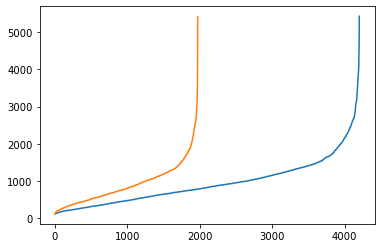

In [291]:
plt.plot(sorted(edf.cds.str.len()))
plt.plot(sorted(tdf.cds.str.len()))

In [292]:
edf.cds.str.len().mean()

942.0687277051129

In [293]:
tdf.cds.str.len().mean()

910.4080081094779

In [215]:
qdf.head()

,Length,EffectiveLength,TPM,NumReads
Name,,,,
AAS80349,1098.0,496.741333,7.978933,792.165667
AAS80350,771.0,251.000000,101.030987,5202.333333
AAS80351,543.0,251.000000,328.978919,17062.333333
AAS80352,1320.0,791.354333,108.038834,17374.000000
AAS80353,339.0,89.000000,199.647982,3365.333333


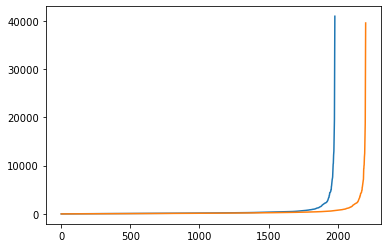

In [219]:
plt.plot(sorted(qdf.TPM))
plt.plot(sorted(qdfo.TPM))

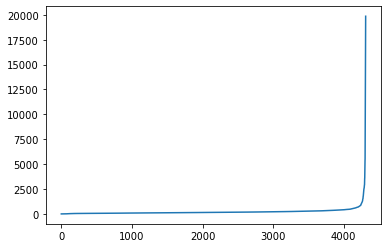

In [222]:
plt.plot(sorted(eqdf.TPM))

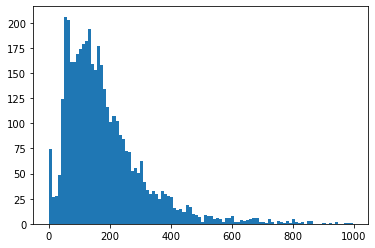

In [235]:
plt.hist(eqdf.query("TPM<1000")['TPM'], bins=100);

In [260]:
eqdf.head()

,Length,EffectiveLength,TPM,NumReads
Name,,,,
K0016_00005,351.0,171.333333,168.006657,144.333333
K0016_00010,593.0,234.663667,215.454963,166.000000
K0016_00015,888.0,399.860667,119.783353,176.000000
K0016_00020,927.0,345.185000,193.013424,182.666667
K0016_00025,1965.0,1054.987667,105.030346,198.333333


In [236]:
eqdf.query("TPM>1000").shape

(63, 4)

In [233]:
np.log1p(500)

6.2166061010848646

In [51]:
qdf = pd.read_parquet("data/thermo/hb27dago_tpm.pq")
qdf.shape

(2204, 4)

In [262]:
eqdf.head()

,Length,EffectiveLength,TPM,NumReads
Name,,,,
K0016_00005,351.0,171.333333,168.006657,144.333333
K0016_00010,593.0,234.663667,215.454963,166.000000
K0016_00015,888.0,399.860667,119.783353,176.000000
K0016_00020,927.0,345.185000,193.013424,182.666667
K0016_00025,1965.0,1054.987667,105.030346,198.333333


In [261]:
edf.columns

Index(['cds', 'host', 'taxonomy', 'strand', 'translation', 'protein_id',
       'db_xref', 'locus_tag', 'res'],
      dtype='object')

In [263]:
edf.columns = ['cds', 'host', 'taxonomy', 'strand', 'translation', 'protein_id',
       'db_xref', 'Name', 'res']
edf.set_index('Name', inplace=True)

In [264]:
edf.head(2)

,cds,host,taxonomy,strand,translation,protein_id,db_xref,res
Name,,,,,,,,
K0016_00005,ATGCATACCTCCGAGTTGCTGAAACACATTTATGACATCAACTTGT...,Escherichia_coli,"[Bacteria, Proteobacteria, Gammaproteobacteria...",1,MHTSELLKHIYDINLSYLLLAQRLIVQDKASAMFRLGINEEMATTL...,QYI31358.1,[],ATCGGCTCAAACATGAAGAAATGAAATGACTGAGTCAGCCGAGAAG...
K0016_00010,ATGAGTGAAAAAAGCATTGTTCAGGAAGCGCGGGATATTCAGCTGG...,Escherichia_coli,"[Bacteria, Proteobacteria, Gammaproteobacteria...",1,,,[],ACGATCTCCAGCAAATTCATACCGGCATCATGCTCTCAACACGCTT...


In [265]:
etdf = edf.join(eqdf)

In [266]:
etdf.shape

(4205, 12)

In [268]:
etdf.query("EffectiveLength > 0").sort_values('TPM', ascending=False).head(10).loc[:,['TPM']]

,TPM
Name,
K0016_20125,19854.640599
K0016_21335,17891.559969
K0016_20750,15315.295486
K0016_13170,13883.880309
K0016_14910,13258.330878
K0016_06460,8181.370643
K0016_21485,7387.235637
K0016_01330,7295.067499
K0016_15100,5551.888455


In [78]:
tdf_48.query("EffectiveLength > 1").sort_values('TPM', ascending=False).head(10).loc[:,['TPM']]

,TPM
Name,
AAS80532,39537.687834
AAS81968,33215.648625
AAS81326,28646.150537
AAS80610,18840.183220
AAS81180,18333.382149
AAS82153,15918.918845
AAS82151,14207.666390
AAS80398,12095.926727
AAS82178,9992.284337


In [91]:
tdf.shape, tdf_48.shape, tdf_20.shape

((1973, 11), (633, 11), (907, 11))

In [92]:
didxs_48 = tdf.sort_values('TPM', ascending=False).head(200).index.difference(tdf_48.sort_values('TPM', ascending=False).head(200).index)
len(didxs_48), didxs_48

(125,
 Index(['AAS80366', 'AAS80367', 'AAS80370', 'AAS80394', 'AAS80424', 'AAS80453',
        'AAS80466', 'AAS80467', 'AAS80474', 'AAS80494',
        ...
        'AAS82121', 'AAS82160', 'AAS82161', 'AAS82210', 'AAS82211', 'AAS82222',
        'AAS82258', 'AAS82287', 'AAS82312', 'AAS82327'],
       dtype='object', name='Name', length=125))

In [93]:
didxs_20 = tdf.sort_values('TPM', ascending=False).head(200).index.difference(tdf_20.sort_values('TPM', ascending=False).head(200).index)
len(didxs_20), didxs_20

(104,
 Index(['AAS80367', 'AAS80370', 'AAS80424', 'AAS80453', 'AAS80466', 'AAS80467',
        'AAS80494', 'AAS80533', 'AAS80620', 'AAS80696',
        ...
        'AAS82118', 'AAS82121', 'AAS82160', 'AAS82210', 'AAS82211', 'AAS82222',
        'AAS82258', 'AAS82287', 'AAS82312', 'AAS82327'],
       dtype='object', name='Name', length=104))

(array([2480.,  236.,  136.,   62.,   52.,   36.,   44.,   50.,   37.,
        1072.]),
 array([ 100.,  192.,  284.,  376.,  468.,  560.,  652.,  744.,  836.,
         928., 1020.]),
 <BarContainer object of 10 artists>)

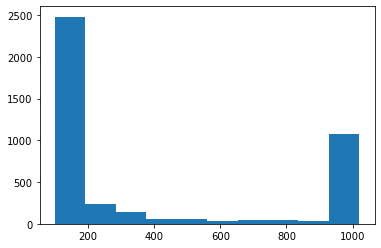

In [299]:
plt.hist(sorted(etdf.res.str.len()))

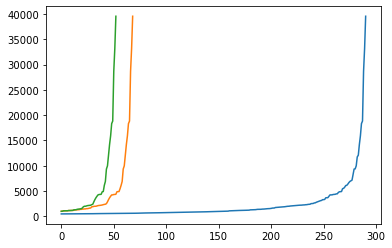

In [113]:
plt.plot(sorted(etdf.query("TPM>500").TPM.values))
plt.plot(sorted(tdf_20.query("TPM>1000").TPM.values))
plt.plot(sorted(tdf_48.query("TPM>1000").TPM.values))

In [322]:
tdf.query("TPM>165").shape, tdf.shape

((974, 12), (1973, 12))

In [334]:
etdf.query(f"TPM<{eperc['5%']}").describe()

,strand,Length,EffectiveLength,TPM,NumReads
count,211.000000,211.000000,211.000000,211.000000,211.000000
mean,0.004739,726.971564,454.319172,27.544249,64.022288
std,1.002367,607.933031,449.923802,17.644287,49.423463
min,-1.000000,126.000000,11.000000,0.000000,0.000000
25%,-1.000000,360.000000,193.815167,10.517464,19.166667
50%,1.000000,522.000000,305.333333,34.983632,74.000000
75%,1.000000,859.500000,532.333333,42.965335,89.333333
max,1.000000,4461.000000,2834.333333,46.956186,302.333333


In [441]:
ecoli_df.groupby('bucket').count()

,cds,host,taxonomy,strand,translation,protein_id,db_xref,res,Length,EffectiveLength,TPM,NumReads,res_gc,cds_gc,res_sliding_gc_30,res_window_gc_10,intergen_len,cat
bucket,,,,,,,,,,,,,,,,,,
high,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421,421
low,2102,2102,2102,2102,2102,2102,2102,2102,2102,2102,2102,2102,2102,2102,2102,2102,2102,2102
medium,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682


In [442]:
thermo_df.groupby('bucket').count()

,cds,host,taxonomy,strand,translation,db_xref,res,Length,EffectiveLength,TPM,NumReads,res_gc,cds_gc,res_sliding_gc_30,res_window_gc_10,intergen_len,cat
bucket,,,,,,,,,,,,,,,,,
high,197,197,197,197,197,197,197,197,197,197,197,197,197,197,197,197,197
low,984,984,984,984,984,984,984,984,984,984,984,984,984,984,984,984,984
medium,788,788,788,788,788,788,788,788,788,788,788,788,788,788,788,788,788


In [443]:
alex_df.groupby('thermo_bucket').count()

,no,seq,thermo,ecoli,cat,res_gc,ecoli_bucket
thermo_bucket,,,,,,,
high,6,6,6,6,6,6,6
low,27,27,27,27,27,27,27
medium,22,22,22,22,22,22,22


In [444]:
alex_df.groupby('ecoli_bucket').count()

,no,seq,thermo,ecoli,cat,res_gc,thermo_bucket
ecoli_bucket,,,,,,,
high,6,6,6,6,6,6,6
low,27,27,27,27,27,27,27
medium,22,22,22,22,22,22,22


In [131]:
tdf.to_parquet("data/thermo/allres_tpm.pq")

In [273]:
etdf.to_parquet("data/thermo/allres_ecoli_tpm.pq")

In [352]:
ehres = []
for e in tdf[tdf.bucket=='high'].res:
    if len(e) <= 100:
        ehres.append(e)
    else:
        ehres.append(e[-100:])
ehres[:3]

['GGGAGAGGCAGAAGAACCTCGAGGGGTACGCCCTGAGGAAGCTCGGGGAAGGATAGCCCTCTTCCTCCTCCCTTCGGCCCCGGGGTGCTAGACTTAGGGC',
 'TCGCCGCAAGCCGGGCCCCGGAGGTCCGCTGGCCCCGGATCCGGGTGGAGGAGGGGTGCACCCTCTGCCCGGTCTGCACCAACGTCTGCCCACGGAGGCG',
 'CCGGCTGCTCTGACCGTTGAGCTAACGGCCCCCGTCCGGGAACGATAGTAGCACAGCCCGGCCCCTTTTGCTGTACTCTTGGGTTGAAGGAGGTGAGCCT']

In [422]:
ecoli_df

,cds,host,taxonomy,strand,translation,protein_id,db_xref,res,Length,EffectiveLength,TPM,NumReads,bucket,res_gc,cds_gc,res_sliding_gc_30,res_window_gc_10,intergen_len,cat
Name,,,,,,,,,,,,,,,,,,,
K0016_00005,ATGCATACCTCCGAGTTGCTGAAACACATTTATGACATCAACTTGT...,Escherichia_coli,"[Bacteria, Proteobacteria, Gammaproteobacteria...",1,MHTSELLKHIYDINLSYLLLAQRLIVQDKASAMFRLGINEEMATTL...,QYI31358.1,[],ATCGGCTCAAACATGAAGAAATGAAATGACTGAGTCAGCCGAGAAG...,351.0,171.333333,168.006657,144.333333,medium,41.734417,46.438746,"[36.666666666666664, 36.666666666666664, 40.0,...","[50.0, 40.0, 36.666666666666664, 42.5, 40.0, 4...",369.0,Ecoli DH5
K0016_00010,ATGAGTGAAAAAAGCATTGTTCAGGAAGCGCGGGATATTCAGCTGG...,Escherichia_coli,"[Bacteria, Proteobacteria, Gammaproteobacteria...",1,,,[],ACGATCTCCAGCAAATTCATACCGGCATCATGCTCTCAACACGCTT...,593.0,234.663667,215.454963,166.000000,medium,49.000000,49.072513,"[46.666666666666664, 46.666666666666664, 46.66...","[50.0, 40.0, 46.666666666666664, 47.5, 50.0, 4...",2.0,Ecoli DH5
K0016_00015,GTGCTTATCTTATTAGGTTACCTGGTTGTTCTCGGTACAGTTTTCG...,Escherichia_coli,"[Bacteria, Proteobacteria, Gammaproteobacteria...",1,MLILLGYLVVLGTVFGGYLMTGGSLGALYQPAELVIIAGAGIGSFI...,QYI31359.1,[],CTGATACGGTGAGGCGCAACATTCCAGCAGCGGTAACGACGTACCG...,888.0,399.860667,119.783353,176.000000,low,53.174603,51.351351,"[56.666666666666664, 56.666666666666664, 60.0,...","[50.0, 60.0, 56.666666666666664, 57.5, 60.0, 5...",126.0,Ecoli DH5
K0016_00020,ATGAAGAATCAAGCGCATCCGATTATTGTCGTCAAACGACGCAAAG...,Escherichia_coli,"[Bacteria, Proteobacteria, Gammaproteobacteria...",1,MKNQAHPIIVVKRRKAKSHGAAHGSWKIAYADFMTAMMAFFLVMWL...,QYI31360.1,[],GCAAAACGCTCTATTCCAGCGAACGTCCGTCGTTTATTGAACTGGA...,927.0,345.185000,193.013424,182.666667,medium,51.000000,53.182309,"[53.333333333333336, 53.333333333333336, 53.33...","[50.0, 50.0, 53.333333333333336, 47.5, 48.0, 5...",0.0,Ecoli DH5
K0016_00025,GTGAGCATGGATATAAGCGATTTTTATCAGACATTTTTTGATGAAG...,Escherichia_coli,"[Bacteria, Proteobacteria, Gammaproteobacteria...",1,MSMDISDFYQTFFDEADELLADMEQHLLVLQPEVPDAEQLNAIFRA...,QYI31361.1,[],GCCGAAAGCCAGAATGAGCCAGTAAGCGCCCTGGAAAAACCTGAGG...,1965.0,1054.987667,105.030346,198.333333,low,57.000000,53.078880,"[60.0, 60.0, 56.666666666666664, 56.6666666666...","[70.0, 60.0, 60.0, 55.0, 56.0, 56.666666666666...",4.0,Ecoli DH5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K0016_00125,ATGGTAAGCGCGCTGTACGCCGTTTTAAGTGCGTTGTTATTAATGA...,Escherichia_coli,"[Bacteria, Proteobacteria, Gammaproteobacteria...",-1,MVSALYAVLSALLLMKFSFDVVRLRMQYRVAYGDGGFSELQSAIRI...,QYI31380.1,[],GAGATCGGAGCAGTTCCGGCTATTCCACAGCAATCTTCTCTTTTCT...,396.0,186.415000,223.193149,155.666667,medium,46.000000,50.757576,"[56.666666666666664, 56.666666666666664, 56.66...","[60.0, 65.0, 56.666666666666664, 52.5, 46.0, 4...",52.0,Ecoli DH5
K0016_00120,ATGTCTCACCGCGACACGCTATTTTCTGCCCCTATCGCCAGACTGG...,Escherichia_coli,"[Bacteria, Proteobacteria, Gammaproteobacteria...",-1,MSHRDTLFSAPIARLGDWTFDERVAEVFPDMIQRSVPGYSNIISMI...,QYI31379.1,[],CTGATGGTGCTGGCGAATCTTTGGTATATGCCCTGGGAGTTGGTTT...,744.0,281.781667,978.281038,346.000000,high,48.000000,50.672043,"[46.666666666666664, 46.666666666666664, 50.0,...","[60.0, 55.0, 46.666666666666664, 52.5, 50.0, 5...",40.0,Ecoli DH5
K0016_00115,ATGATCGACTTTGGTAACTTTTATTCTCTGATTGCCAAAAATCATC...,Escherichia_coli,"[Bacteria, Proteobacteria, Gammaproteobacteria...",-1,MIDFGNFYSLIAKNHLSHWLETLPAQIANWQREQQHGLFKQWSNAV...,QYI31378.1,[],ATAAAGCACGCCTGCATAACGCCGGTTTTGAGCATAGTGAGCTGTG...,972.0,585.333333,77.779144,152.666667,low,49.000000,52.057613,"[50.0, 50.0, 53.333333333333336, 56.6666666666...","[40.0, 45.0, 50.0, 47.5, 50.0, 48.333333333333...",0.0,Ecoli DH5


In [431]:
alex_df.groupby("ecoli_bucket")["ecoli"].describe()

,count,mean,std,min,25%,50%,75%,max
ecoli_bucket,,,,,,,,
high,6.0,59657.175020,25370.659928,32860.263737,39742.534091,55319.046077,75679.160808,97428.465084
low,27.0,1190.649500,638.300299,239.113349,635.806300,1144.281536,1682.548280,2212.911912
medium,22.0,10006.371941,10036.241784,2367.645751,2724.737825,4749.921069,13285.418523,32527.347427


In [489]:
alex_df

,no,seq,thermo,ecoli,cat,res_gc,thermo_bucket,ecoli_bucket
0,1,ATGTCGCGTATAGATGATGTACAGTATAGTGGTGTCCCACTCTAGA...,86163.203810,13198.831482,ARES,47.530864,high,medium
1,2,CTATCATACGCACAATCATGTGAACAATAATGGTTTATAAAGTTAT...,55994.396516,2113.209101,ARES,35.616438,high,low
2,3,TTTATGAACGCCCATACATATTCCAAGATCGGTATATGGCTCCGAT...,52424.329129,461.302681,ARES,43.349754,high,low
3,4,ATATCTATGCGTCAGGTGATACATTTTTACAGATTACGAGTAAAGT...,52118.676687,2384.512305,ARES,47.290640,high,medium
4,5,GAGGTGATAATATACCTGACATTCAATGTATTTTGTTCTCTCCATG...,36051.261369,37039.626885,ARES,37.378641,high,high
5,6,GCGTGTTCTTTTGTGGACCTGAGCTAGCTAAAGGCAGAGTGGTAAG...,30413.664815,27032.757116,ARES,41.871921,medium,medium
6,7,CGAAAAAAAGTAAGAATGAGCAAAGGAGAAGAACTTTTCACTGGAT...,24212.348343,32860.263737,ARES,42.857143,medium,high
7,8,GGACGCAGTGACAGGTGCTATCTTTTAATTACGTATAAACGGTTGT...,20317.202339,12623.955893,ARES,46.728972,medium,medium
8,9,GAATGAATTCGGCTCAACACAAATCTGTCGTTGTTAATCGTGTGTG...,19167.646589,1928.764470,ARES,46.798030,medium,low
9,10,TCAAGATGACTAAAGAGAGGTCGTAAATTACTAATACTCGTATTGT...,19152.318993,1690.783535,ARES,44.334975,medium,low


## Motif Discovery

In [513]:
def df_to_fasta(df, bucket, bg_bucket, fname, res="res",bucket_col="bucket"):
    if bucket == "":
        with open(f"{fname}_allseqs.fa", "w") as f:
            for idx,e in zip(df.index.values,df[res].values):
                f.writelines(f">{idx}\n{e}\n")
        return

    res_seqs = []
    for e in df[df[bucket_col]==bucket][res]:
        if len(e) <= 100:
            res_seqs.append(e)
        else:
            res_seqs.append(e[-100:])
    with open(f"{fname}_100bp.fa", "w") as f:
        for idx,e in zip(df[df[bucket_col]==bucket].index.values,res_seqs):
            f.writelines(f">{idx}\n{e}\n")

    with open(f"{fname}_allbp.fa", "w") as f:
        for idx,e in zip(df[df[bucket_col]==bucket].index.values,df[df[bucket_col]==bucket][res].values):
            f.writelines(f">{idx}\n{e}\n")

    with open(f"{fname}_bg.fa", "w") as f:
        for idx,e in zip(df[df[bucket_col]==bg_bucket].index.values,df[df[bucket_col]==bg_bucket][res].values):
            f.writelines(f">{idx}\n{e}\n")

In [356]:
!mkdir motif_fasta

In [492]:
df_to_fasta(alex_df, "", "", "data/motif_fasta/ares", res="seq")

In [437]:
df_to_fasta(ecoli_df, 'high', 'low', 'data/motif_fasta/ecoli_high')
df_to_fasta(ecoli_df, 'low','high', 'data/motif_fasta/ecoli_low')
df_to_fasta(thermo_df, 'high', 'low', 'data/motif_fasta/thermo_high')
df_to_fasta(thermo_df, 'low','high', 'data/motif_fasta/thermo_low')
df_to_fasta(alex_df, 'high', 'low', 'data/motif_fasta/ares_thermo_high', res="seq", bucket_col="thermo_bucket")
df_to_fasta(alex_df, 'low','high', 'data/motif_fasta/ares_thermo_low', res="seq", bucket_col="thermo_bucket")
df_to_fasta(alex_df, 'high', 'low', 'data/motif_fasta/ares_ecoli_high', res="seq", bucket_col="ecoli_bucket")
df_to_fasta(alex_df, 'low','high', 'data/motif_fasta/ares_ecoli_low', res="seq", bucket_col="ecoli_bucket")

In [390]:
tmpdf = pd.read_excel("data/motif_fasta/220623_thermus_53_hits(1).xlsx", names=['no', 'seq','thermo', 'ecoli'])
tmpdf.head()

,no,seq,thermo,ecoli
0,1,ATGTCGCGTATAGATGATGTACAGTATAGTGGTGTCCCACTCTAGA...,86163.203810,13198.831482
1,2,CTATCATACGCACAATCATGTGAACAATAATGGTTTATAAAGTTAT...,55994.396516,2113.209101
2,3,TTTATGAACGCCCATACATATTCCAAGATCGGTATATGGCTCCGAT...,52424.329129,461.302681
3,4,ATATCTATGCGTCAGGTGATACATTTTTACAGATTACGAGTAAAGT...,52118.676687,2384.512305
4,5,GAGGTGATAATATACCTGACATTCAATGTATTTTGTTCTCTCCATG...,36051.261369,37039.626885


In [391]:
alex_cds = "ATGAGCAAAGGAGAAGAACTTTTCACTGGAGTTGTCCCAATTCTTGTTGAATTAGATGGTGATGTTAATGGGCACAAATTTTCTGTCCGTGGAGAGGGTGAAGGTGATGCTACAAACGGAAAACTCACCCTTAAATTTATTTGCACTACTGGAAAACTACCTGTTCCGTGGCCAACACTTGTCACTACTCTGACCTATGGTCTTATGTGCTTTTCCCGTTATCCGGATCACATGAAACGGCATGACTTTTTCAAGAGTGCCATGCCCGAAGGTTATGTACAGGAACGCACTATATCTTTCAAAGATGACGGGACCTACAAGACGCGTGCTGAAGTCAAGTTTGAAGGTGATACCCTTGTTAATCGTATCGAGTTAAAGGGTATTGATTTTAAAGAAGATGGAAACATTCTTGGACACAAACTCGAGTACAACTTTAACTCACACAATGTATACATCACGGCAGACAAACAAAAGAATGGAATCAAAGCTAACTTCAAAATTCGCCACAACGTTGAAGATGGTTCCGTTCAACTAGCAGACCATTATCAACAAAATACTCCAATTGGCGATGGCCCTGTCCTTTTACCAGACAACCATTACCTGTCGACACAATCTGTCCTTTCGAAAGATCCCAACGAAAAGCGTGACCACATGGTCCTTCTTGAGTTTGTAACTGCTGCTGGGATTACACATGGCATGGATGAGCTCTACAAATAATAA"


In [392]:
SeqUtils.GC(alex_cds)

41.94444444444444

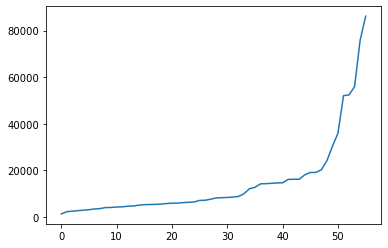

In [363]:
plt.plot(sorted(tmpdf.thermo))

In [366]:
tmpdf.query("thermo > 20000").shape, tmpdf.shape

((9, 4), (56, 4))

In [368]:
tmpdf.describe(percentiles=[0.05,0.5,0.7,0.9,0.95])

,thermo,ecoli
count,56.000000,56.000000
mean,14701.704693,10899.955926
std,17732.230452,20129.520595
min,1374.274316,166.762508
5%,2718.007366,328.189876
50%,7961.971114,2290.278832
70%,14580.522399,4749.921069
90%,33232.463092,32693.805582
95%,53316.845976,51585.150893
max,86163.203810,97428.465084


In [375]:
tmpdf['slen'] = tmpdf.seq.str.len()

In [377]:
tmpdf

,no,seq,thermo,ecoli,slen
0,1,ATGTCGCGTATAGATGATGTACAGTATAGTGGTGTCCCACTCTAGA...,86163.203810,13198.831482,162.0
1,2,CTATCATACGCACAATCATGTGAACAATAATGGTTTATAAAGTTAT...,55994.396516,2113.209101,146.0
2,3,TTTATGAACGCCCATACATATTCCAAGATCGGTATATGGCTCCGAT...,52424.329129,461.302681,203.0
3,4,ATATCTATGCGTCAGGTGATACATTTTTACAGATTACGAGTAAAGT...,52118.676687,2384.512305,203.0
4,5,GAGGTGATAATATACCTGACATTCAATGTATTTTGTTCTCTCCATG...,36051.261369,37039.626885,206.0
5,6,GCGTGTTCTTTTGTGGACCTGAGCTAGCTAAAGGCAGAGTGGTAAG...,30413.664815,27032.757116,203.0
6,7,CGAAAAAAAGTAAGAATGAGCAAAGGAGAAGAACTTTTCACTGGAT...,24212.348343,32860.263737,203.0
7,8,GGACGCAGTGACAGGTGCTATCTTTTAATTACGTATAAACGGTTGT...,20317.202339,12623.955893,214.0
8,9,GAATGAATTCGGCTCAACACAAATCTGTCGTTGTTAATCGTGTGTG...,19167.646589,1928.764470,203.0
9,10,TCAAGATGACTAAAGAGAGGTCGTAAATTACTAATACTCGTATTGT...,19152.318993,1690.783535,203.0


In [369]:
tmpdf.query("thermo > 50000").shape, tmpdf.shape

((5, 4), (56, 4))

In [370]:
tmpdf.query("thermo < 3000").shape, tmpdf.shape

((5, 4), (56, 4))

In [372]:
with open("data/motif_fasta/thermo_alex.fa", "w") as f:
    for idx,e in zip(tmpdf.no.values,tmpdf.seq.values):
            f.writelines(f">{idx}\n{e}\n")

In [373]:
with open("data/motif_fasta/ecoli_alex.fa", "w") as f:
    for idx,e in zip(tmpdf.no.values,tmpdf.seq.values):
            f.writelines(f">{idx}\n{e}\n")

In [140]:
from Bio import SeqIO

records = SeqIO.parse("data/thermo/ecoli_dh5.gb", "genbank")
#count = SeqIO.write(records, "data/thermo/ecoli_dh5.gb", "genbank")
#print("Converted %i records" % count)

In [137]:
SeqIO.write(records, "data/thermo/ecoli_dh5.cdna", "fasta")

1

In [193]:
records = SeqIO.parse("data/thermo/gb/Thermus_thermophilus_hb27_gca_000008125.ASM812v1.53.chromosome.Chromosome.dat", "genbank")
data = ""
for r in records.records:
    for f in r.features:
        if f.type == "CDS":
            gene = f.qualifiers['gene'][0] if "gene" in f.qualifiers else ""
            #data += f">{f.qualifiers['locus_tag'][0]} cdna gene:{gene} gene_biotype:{f.qualifiers['product'][0]}\n"
            data += f">{f.qualifiers['protein_id'][0]} cdna gene:{gene}\n"
            data += f"{f.extract(r.seq).__str__()}\n"
with open("data/thermo/thermo.cdna", "w") as f:
    f.writelines(data)

In [138]:
tdf.query("TPM >= 4000").shape

(35, 12)

In [206]:
cfa = SeqIO.parse("data/thermo/thermo.cdna", "fasta")
fa = SeqIO.parse("data/thermo/Thermus_thermophilus_hb27_gca_000008125.ASM812v1.cdna.all.fa", "fasta")

In [207]:
cfas = {}
for f in cfa:
    cfas[f.id] = f.seq

In [208]:
fas = {}
for f in fa:
    fas[f.id] = f.seq

In [209]:
len(cfas),len(fas)

(1982, 2210)

In [213]:
for k in cfas.keys():
    if cfas[k] != fas[k]:
        print(k)

In [121]:
tdf.query("TPM < 4000 and TPM >= 1000").shape

(103, 11)

In [ ]:
tdf.cut()

In [122]:
tdf.query("TPM < 1000").shape

(1831, 11)

In [116]:
tdf.TPM.max(),qdf.TPM.max()

(39537.687834000004, 39537.687834000004)

In [86]:
df_48 = pd.read_parquet("data/thermo/gb/Thermus_thermophilus_hb27_gca_000008125.ASM812v1.53.chromosome.Chromosome_mres48.pq")
df_20 = pd.read_parquet("data/thermo/gb/Thermus_thermophilus_hb27_gca_000008125.ASM812v1.53.chromosome.Chromosome_mres20.pq")
df_48.shape,df_20.shape

((633, 8), (907, 8))

In [87]:
df_48.head()

,cds,host,taxonomy,strand,translation,protein_id,db_xref,res
0,ATGGGCCTTTTCGCTGGCAAAGGGGTGCTGGTGACCGGAGGGGCCC...,Thermus_thermophilus,"[Bacteria, Deinococcus-Thermus, Deinococci, Th...",1,MGLFAGKGVLVTGGARGIGRAIAQAFAREGALVALCDLRPEGKEVA...,AAS80350,"[Uniprot/SPTREMBL:Q72LQ6, GO:0016491, Interpro...",ACCTTACTTACCCCCCCTCTTCTCTTCCCTTGTCAAGCCCCAGCCC...
1,ATGAAGAAGGCGCTTTTGCTGGTGGCGGCGCTGGGCGTGGCCTTCG...,Thermus_thermophilus,"[Bacteria, Deinococcus-Thermus, Deinococci, Th...",1,MKKALLLVAALGVAFAQQAKPEDVIKEQCARAKVVAEFWHGFTGGA...,AAS80359,"[Uniprot/SPTREMBL:Q72LP7, GO:0055085, Interpro...",GCTTGAACGTGCCCTGACGGGGGGCAGGGTATACTCTCCCCGGAGG...
2,ATGCCCAAGGGGTATCACGACCGCGTGGCCTTCGTGGACCTCTCCA...,Thermus_thermophilus,"[Bacteria, Deinococcus-Thermus, Deinococci, Th...",1,MPKGYHDRVAFVDLSTGKVWYESFGEAFWRRYLGGRALAAYLLLRH...,AAS80360,"[Uniprot/SPTREMBL:Q72LP6, GO:0009055, GO:00164...",AGGCCCTTTCGCCTTACCGGTTCGGGCCCCCGCCCGCTTCGGGCGG...
3,GTGGACGCCTTCGCCGACTGGCTCTTCGTGGCCCTCTGGGTCCTCG...,Thermus_thermophilus,"[Bacteria, Deinococcus-Thermus, Deinococci, Th...",1,MDAFADWLFVALWVLGVLLTLLPFVPATLVILFGALVHELLVGFRE...,AAS80362,"[Uniprot/SPTREMBL:Q72LP4, GO:0016021, Interpro...",GCCGGTGGGGCCATTCTACCGCCTCTTTCCCTTCTCACCCCGCCTT...
4,ATGTGGTATCCTCTAGCGGCGATGAAGGGGGTCCTCGAGGCCCTGC...,Thermus_thermophilus,"[Bacteria, Deinococcus-Thermus, Deinococci, Th...",1,MWYPLAAMKGVLEALHQGDYDTAIDLLTRKALFGREREAKEAWLLL...,AAS80384,"[Uniprot/SPTREMBL:Q72LM2, GO:0005515, GO:00428...",GGTCTACCTCCCTTGCCCTATGGTAGCGCCTTGCCGGTGGGAAGAC...


In [88]:
df_48.columns = ['cds', 'host', 'taxonomy', 'strand', 'translation', 'Name',
       'db_xref', 'res']
df_48.set_index('Name', inplace=True)
tdf_48 = df_48.join(qdf)
df_48.shape,tdf_48.shape

((633, 7), (633, 11))

In [89]:
df_20.columns = ['cds', 'host', 'taxonomy', 'strand', 'translation', 'Name',
       'db_xref', 'res']
df_20.set_index('Name', inplace=True)
tdf_20 = df_20.join(qdf)
df_20.shape,tdf_20.shape

((907, 7), (907, 11))

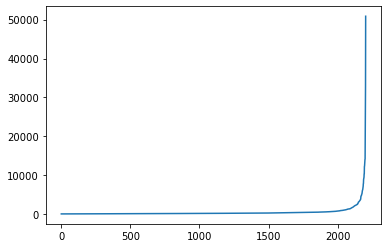

In [143]:
plt.plot(sorted(oqdf.TPM))

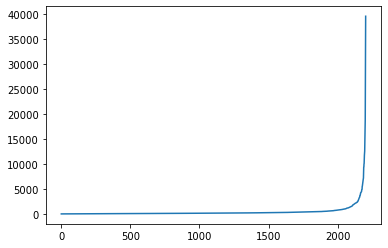

In [144]:
plt.plot(sorted(qdf.TPM))

In [124]:
oqdf1.sort_values('TPM', ascending=False).head(40)

,Name,Length,EffectiveLength,TPM,NumReads
409,AAS80532,189,7.000,48609.656456,40901.0
1201,AAS81326,294,46.000,28966.166900,160163.0
1841,AAS81968,207,9.000,24900.582380,26938.0
2026,AAS82153,258,22.000,19442.955023,51416.0
1521,AAS81646,114,3.000,14403.477417,5194.0
1055,AAS81180,675,251.000,13541.098796,408546.0
1247,AAS81372,84,3.000,11988.107985,4323.0
2024,AAS82151,240,16.000,11922.593515,22930.0
275,AAS80398,183,7.000,11459.238345,9642.0
1957,AAS82084,267,27.000,10675.199559,34646.0


# Meme Suite

In [484]:
def parse_streme_seqs(fname):
    seqs = []
    with open(fname, "r") as f:
        for l in f.readlines():
            cols = l.split()
            if cols[0] not in ["motif_ID", "#"]:
                if cols[0] not in seqs:
                    seqs.append(cols[0])
    return seqs

In [485]:
mseqs = parse_streme_seqs("data/motif_fasta/tmp/sequences.tsv")

In [500]:
experiments = {
    "ecoli_high": ["data/motif_fasta/ecoli_high_100bp.fa", "data/motif_fasta/ecoli_high_bg.fa", "data/motif_fasta/ares_allseqs.fa"],
    "ecoli_low": ["data/motif_fasta/ecoli_low_100bp.fa", "data/motif_fasta/ecoli_low_bg.fa", "data/motif_fasta/ares_allseqs.fa"],
    "thermo_high": ["data/motif_fasta/thermo_high_100bp.fa", "data/motif_fasta/thermo_high_bg.fa", "data/motif_fasta/ares_allseqs.fa"],
    "thermo_low": ["data/motif_fasta/thermo_low_100bp.fa", "data/motif_fasta/thermo_low_bg.fa", "data/motif_fasta/ares_allseqs.fa"],
}

In [870]:
for exp_name, files in experiments.items():
    print(f"Processing {exp_name}")
    streme = f"streme --verbosity 1 --oc data/motif_fasta/{exp_name} --dna --minw 6 --maxw 18 --thresh 0.05 --align right --p {files[0]} --n {files[1]}"
    fimo = f"fimo --oc data/motif_fasta/{exp_name} --verbosity 1 --thresh 0.0002  data/motif_fasta/{exp_name}/streme.txt {files[2]}"
    ret = subprocess.call(streme.split())
    if ret != 0:
        print(f"Failed in executing STREME for {exp_name}")
    ret = subprocess.call(fimo.split())
    if ret != 0:
        print(f"Failed in executing FIMO for {exp_name}")

Processing ecoli_high


# Warning: p-values will be inaccurate if primary and control
#          sequences have different length distributions.
Can't locate XML/Parser/Expat.pm in @INC (you may need to install the XML::Parser::Expat module) (@INC contains: /cluster/work/gurvinde/.env1/lib/perl5/5.32/site_perl /cluster/work/gurvinde/.env1/lib/perl5/site_perl /cluster/work/gurvinde/.env1/lib/perl5/5.32/vendor_perl /cluster/work/gurvinde/.env1/lib/perl5/vendor_perl /cluster/work/gurvinde/.env1/lib/perl5/5.32/core_perl /cluster/work/gurvinde/.env1/lib/perl5/core_perl .) at /cluster/work/gurvinde/.env1/libexec/meme-5.4.1/streme_xml_to_html line 21.
BEGIN failed--compilation aborted at /cluster/work/gurvinde/.env1/libexec/meme-5.4.1/streme_xml_to_html line 21.
# Warning: streme_xml_to_html exited abnormally and may have failed to create HTML output.


Processing ecoli_low


# Warning: p-values will be inaccurate if primary and control
#          sequences have different length distributions.
Can't locate XML/Parser/Expat.pm in @INC (you may need to install the XML::Parser::Expat module) (@INC contains: /cluster/work/gurvinde/.env1/lib/perl5/5.32/site_perl /cluster/work/gurvinde/.env1/lib/perl5/site_perl /cluster/work/gurvinde/.env1/lib/perl5/5.32/vendor_perl /cluster/work/gurvinde/.env1/lib/perl5/vendor_perl /cluster/work/gurvinde/.env1/lib/perl5/5.32/core_perl /cluster/work/gurvinde/.env1/lib/perl5/core_perl .) at /cluster/work/gurvinde/.env1/libexec/meme-5.4.1/streme_xml_to_html line 21.
BEGIN failed--compilation aborted at /cluster/work/gurvinde/.env1/libexec/meme-5.4.1/streme_xml_to_html line 21.
# Warning: streme_xml_to_html exited abnormally and may have failed to create HTML output.


Processing thermo_high


# Warning: p-values will be inaccurate if primary and control
#          sequences have different length distributions.
Can't locate XML/Parser/Expat.pm in @INC (you may need to install the XML::Parser::Expat module) (@INC contains: /cluster/work/gurvinde/.env1/lib/perl5/5.32/site_perl /cluster/work/gurvinde/.env1/lib/perl5/site_perl /cluster/work/gurvinde/.env1/lib/perl5/5.32/vendor_perl /cluster/work/gurvinde/.env1/lib/perl5/vendor_perl /cluster/work/gurvinde/.env1/lib/perl5/5.32/core_perl /cluster/work/gurvinde/.env1/lib/perl5/core_perl .) at /cluster/work/gurvinde/.env1/libexec/meme-5.4.1/streme_xml_to_html line 21.
BEGIN failed--compilation aborted at /cluster/work/gurvinde/.env1/libexec/meme-5.4.1/streme_xml_to_html line 21.
# Warning: streme_xml_to_html exited abnormally and may have failed to create HTML output.
# Warning: p-values will be inaccurate if primary and control
#          sequences have different length distributions.


Processing thermo_low


Can't locate XML/Parser/Expat.pm in @INC (you may need to install the XML::Parser::Expat module) (@INC contains: /cluster/work/gurvinde/.env1/lib/perl5/5.32/site_perl /cluster/work/gurvinde/.env1/lib/perl5/site_perl /cluster/work/gurvinde/.env1/lib/perl5/5.32/vendor_perl /cluster/work/gurvinde/.env1/lib/perl5/vendor_perl /cluster/work/gurvinde/.env1/lib/perl5/5.32/core_perl /cluster/work/gurvinde/.env1/lib/perl5/core_perl .) at /cluster/work/gurvinde/.env1/libexec/meme-5.4.1/streme_xml_to_html line 21.
BEGIN failed--compilation aborted at /cluster/work/gurvinde/.env1/libexec/meme-5.4.1/streme_xml_to_html line 21.
# Warning: streme_xml_to_html exited abnormally and may have failed to create HTML output.


In [871]:
alex_df.loc[:,["no","ecoli","ecoli_bucket","thermo_bucket"]].head()

,no,ecoli,ecoli_bucket,thermo_bucket
0,1,13198.831482,medium,high
1,2,2113.209101,low,high
2,3,461.302681,low,high
3,4,2384.512305,medium,high
4,5,37039.626885,high,high


In [872]:
ehs_df = pd.read_csv("data/motif_fasta/ecoli_high/sequences.tsv", sep="\t")
els_df = pd.read_csv("data/motif_fasta/ecoli_low/sequences.tsv", sep="\t")
ths_df = pd.read_csv("data/motif_fasta/thermo_high/sequences.tsv", sep="\t")
tls_df = pd.read_csv("data/motif_fasta/thermo_low/sequences.tsv", sep="\t")
ehs_df.shape,els_df.shape,ths_df.shape,tls_df.shape

((8824, 7), (10874, 7), (1925, 7), (4034, 7))

In [873]:
ehf_df = pd.read_csv("data/motif_fasta/ecoli_high/fimo.tsv", sep="\t")
elf_df = pd.read_csv("data/motif_fasta/ecoli_low/fimo.tsv", sep="\t")
thf_df = pd.read_csv("data/motif_fasta/thermo_high/fimo.tsv", sep="\t")
tlf_df = pd.read_csv("data/motif_fasta/thermo_low/fimo.tsv", sep="\t")
ehf_df.shape,elf_df.shape,thf_df.shape,tlf_df.shape

((17, 10), (29, 10), (34, 10), (34, 10))

In [874]:
ecoli_dict = alex_df.set_index('no').ecoli.to_dict()
seq_len_dict = alex_df.set_index('no').seq.str.len().to_dict()
thermo_dict = alex_df.set_index('no').thermo.to_dict()

In [875]:
ehf_df['exp'] = ehf_df.sequence_name.map(ecoli_dict)
elf_df['exp'] = elf_df.sequence_name.map(ecoli_dict)
thf_df['exp'] = thf_df.sequence_name.map(thermo_dict)
tlf_df['exp'] = tlf_df.sequence_name.map(thermo_dict)
ehf_df['slen'] = ehf_df.sequence_name.map(seq_len_dict)
elf_df['slen'] = elf_df.sequence_name.map(seq_len_dict)
thf_df['slen'] = thf_df.sequence_name.map(seq_len_dict)
tlf_df['slen'] = tlf_df.sequence_name.map(seq_len_dict)
ehf_df = ehf_df.dropna()
elf_df = elf_df.dropna()
thf_df = thf_df.dropna()
tlf_df = tlf_df.dropna()
ehf_df.shape,elf_df.shape,thf_df.shape,tlf_df.shape

((14, 12), (26, 12), (31, 12), (31, 12))

In [876]:
thf_df.query("strand=='+'").exp.describe(percentiles=[0.5,0.8,0.9,0.95,0.99])

count       15.000000
mean     16878.339305
std      24126.034298
min       4333.645503
50%       8435.291500
80%      11255.125824
90%      52018.944911
95%      75856.516243
99%      75856.516243
max      75856.516243
Name: exp, dtype: float64

In [877]:
ehf_df.query("strand=='+'").exp.describe(percentiles=[0.5,0.8,0.9,0.95,0.99])

count        7.000000
mean      9095.889024
std      10969.384325
min       1588.686686
50%       2743.831378
80%      21079.844383
90%      25059.473048
95%      25059.473048
99%      25059.473048
max      25059.473048
Name: exp, dtype: float64

In [820]:
thf_df.query("strand=='+'").exp.describe(percentiles=[0.5,0.8,0.9,0.95,0.99])

count       15.000000
mean     16878.339305
std      24126.034298
min       4333.645503
50%       8435.291500
80%      11255.125824
90%      52018.944911
95%      75856.516243
99%      75856.516243
max      75856.516243
Name: exp, dtype: float64

In [812]:
ehf_df.query("strand=='+'").exp.describe(percentiles=[0.5,0.8,0.9,0.95,0.99])

count        7.000000
mean      9095.889024
std      10969.384325
min       1588.686686
50%       2743.831378
80%      21079.844383
90%      25059.473048
95%      25059.473048
99%      25059.473048
max      25059.473048
Name: exp, dtype: float64

In [798]:
alex_df.describe(percentiles=[0.5,0.8,0.9,0.95,0.99,0.999])

,thermo,ecoli,res_gc
count,55.000000,55.000000,55.000000
mean,14944.021609,11095.104897,43.826481
std,17801.846534,20261.517965,7.339462
min,2320.203090,239.113349,26.470588
50%,8239.074447,2367.645751,42.857143
80%,18342.246563,13875.143738,46.742783
90%,33796.222748,32727.097213,48.508385
95%,53495.349346,52331.929930,57.647059
99%,80597.592524,88004.459160,69.906470
99.9%,85606.642681,96486.064492,71.276361


In [707]:
alex_df.query("no=='12'").seq.array[0][164:173]

'GGAGGTAAG'

In [708]:
SeqUtils.Seq('GGAGGTAAG').reverse_complement()

Seq('CTTACCTCC')

In [766]:
ths_df.groupby("motif_ID").seq_Class.value_counts()

motif_ID      seq_Class
1-AKTHTASCM   tp            86
              fp            33
2-MTWRCG      fp           485
              tp           165
3-GAAAGGA     fp           224
              tp           106
4-CTCACCTCC   tp            33
              fp            25
5-CAAATC      fp           157
              tp            72
6-AAGGAGGGAG  tp            10
              fp             2
Name: seq_Class, dtype: int64

In [733]:
ths_df.query("motif_ID=='2-GCTCCT'")

,motif_ID,motif_ALT_ID,motif_P-value,seq_ID,seq_Score,seq_Class,is_holdout?
124,2-GCTCCT,STREME-2,0.014,AAS81665,9.95,tp,0.0
125,2-GCTCCT,STREME-2,0.014,AAS82161,9.95,tp,0.0
126,2-GCTCCT,STREME-2,0.014,AAS81121,9.95,fp,0.0
127,2-GCTCCT,STREME-2,0.014,AAS82308,9.95,fp,0.0
128,2-GCTCCT,STREME-2,0.014,AAS81471,9.95,fp,0.0
...,...,...,...,...,...,...,...
797,2-GCTCCT,STREME-2,0.014,AAS81305,3.59,fp,0.0
798,2-GCTCCT,STREME-2,0.014,AAS81286,3.59,fp,0.0
799,2-GCTCCT,STREME-2,0.014,AAS80705,3.59,fp,0.0
800,2-GCTCCT,STREME-2,0.014,AAS81819,3.59,fp,0.0


In [768]:
thf_df.query("motif_id=='1-AKTHTASCM'")

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,exp,slen
3,1-AKTHTASCM,STREME-1,39,10.0,18.0,-,11.60710,0.000029,0.505,AGTATAGCA,5352.844331,203.0
17,1-AKTHTASCM,STREME-1,13,56.0,64.0,+,10.58330,0.000094,0.505,AGTGTACCA,16234.321431,203.0
18,1-AKTHTASCM,STREME-1,44,83.0,91.0,+,10.58330,0.000094,0.505,AGTGTACCA,4333.645503,203.0
20,1-AKTHTASCM,STREME-1,19,40.0,48.0,-,10.54760,0.000104,0.505,ATTATAGCA,14270.018728,203.0
25,1-AKTHTASCM,STREME-1,27,169.0,177.0,+,9.64286,0.000190,0.738,AGTTTAGCG,7684.867781,203.0


<BarContainer object of 8 artists>

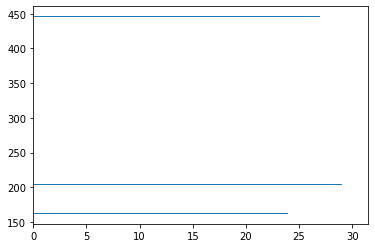

In [750]:
plt.barh(thf_df.query("motif_id=='2-GCTCCT'").slen.array, thf_df.query("motif_id=='2-GCTCCT'").index.array)

In [728]:
thf_df.groupby("motif_id").exp.describe()

,count,mean,std,min,25%,50%,75%,max
motif_id,,,,,,,,
1-AKTMTASCMCVYSSBS,8.0,19172.298662,20751.575767,4333.645503,5826.642388,8435.291500,25226.610107,52424.329129
2-GCTCCT,8.0,32619.806704,33591.765987,4760.126591,8543.439649,12369.748665,58282.375908,86163.203810
3-GAAAGGA,2.0,6428.137727,2838.544087,4420.983954,5424.560841,6428.137727,7431.714614,8435.291500
4-TRNSNYA,2.0,6022.454120,0.000000,6022.454120,6022.454120,6022.454120,6022.454120,6022.454120
5-CCCGGGGCCCC,8.0,15919.626234,24273.888352,4760.126591,7369.337483,8435.291500,8435.291500,75856.516243
6-CTAGGCC,3.0,5855.747956,1594.378485,4760.126591,4941.188043,5122.249495,6403.558638,7684.867781


In [661]:
ecoli_df.query("bucket=='high'").shape

(421, 19)

In [729]:
ehs_df.groupby("motif_ID").seq_Class.value_counts()

motif_ID       seq_Class
1-TAAGGAGAR    fp            261
               tp            155
2-CKWTAASGHAR  fp            898
               tp            314
3-CTKGTTTD     fp            896
               tp            283
4-TAAGAK       fp            682
               tp            240
5-AAAACA       fp           1254
               tp            363
6-CAGGCAA      fp           1257
               tp            351
7-YMTAKR       fp           1465
               tp            381
8-ATGAAAC      tp             11
               fp              6
Name: seq_Class, dtype: int64

In [730]:
ehf_df.groupby("motif_id").exp.describe()

,count,mean,std,min,25%,50%,75%,max
motif_id,,,,,,,,
1-TAAGGAGAR,5.0,6356.732085,10481.816334,461.302681,1690.783535,2204.455408,2367.645751,25059.473048
2-CKWTAASGHAR,1.0,5161.329722,NaN,5161.329722,5161.329722,5161.329722,5161.329722,5161.329722
3-CTKGTTTD,2.0,2166.259032,816.810644,1588.686686,1877.472859,2166.259032,2455.045205,2743.831378
6-CAGGCAA,2.0,12723.683746,17445.440534,387.894443,6555.789095,12723.683746,18891.578397,25059.473048
8-ATGAAAC,4.0,1922.723074,751.716162,962.945757,1575.481256,1992.057582,2339.299400,2743.831378


In [692]:
alex_df.seq.str.contains("ATAGC").sum()

9

In [769]:
ehf_df.strand.value_counts()

+    7
-    7
Name: strand, dtype: int64

In [770]:
thf_df.strand.value_counts()

-    14
+    12
Name: strand, dtype: int64

In [710]:
ehf_df.query("motif_id=='2-AAACCTC'")

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,exp
2,2-AAACCTC,STREME-2,PslpA,53.0,59.0,-,11.09360,0.000065,0.33,AAACCTC,62786.836444
3,2-AAACCTC,STREME-2,33,117.0,123.0,-,11.09360,0.000065,0.33,AAACCTC,2655.199517
5,2-AAACCTC,STREME-2,8,148.0,154.0,-,9.62573,0.000119,0.33,ACACCTC,12623.955893
6,2-AAACCTC,STREME-2,37,164.0,170.0,-,9.62573,0.000119,0.33,ACACCTC,2212.911912
7,2-AAACCTC,STREME-2,42,183.0,189.0,-,9.62573,0.000119,0.33,ACACCTC,2367.645751
8,2-AAACCTC,STREME-2,41,185.0,191.0,-,9.62573,0.000119,0.33,ACACCTC,303.691364
9,2-AAACCTC,STREME-2,PslpA,186.0,192.0,-,9.62573,0.000119,0.33,ACACCTC,62786.836444


In [674]:
ehf_df.query("motif_id=='5-ATAACAAAV'")

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,exp
10,5-ATAACAAAV,STREME-5,39,25.0,33.0,-,9.43151,0.000126,0.688,ATAACAATC,97428.465084
14,5-ATAACAAAV,STREME-5,39,7.0,15.0,-,9.26712,0.000153,0.688,ATAGCAAAA,97428.465084
16,5-ATAACAAAV,STREME-5,22,154.0,162.0,-,9.19178,0.000165,0.688,ATACCAAAC,1779.659756
17,5-ATAACAAAV,STREME-5,49,8.0,16.0,-,9.07534,0.000177,0.688,AGAACAAAA,79976.602262
18,5-ATAACAAAV,STREME-5,5,31.0,39.0,-,9.07534,0.000177,0.688,AGAACAAAA,37039.626885


In [686]:
alex_df.query("no=='48'").seq.values

array(['TGGGGTCTTGGTTGTTGGTATGTTGAAGGTATTAATTGTTATTGCGTTGGCGTTCGTTCTGTACGTGTTAGGGATGCCCTAAGGCTTGAGCCTAGGTTTGTAAGTTACCCCTCTAACTCTACATTGAGATCTGGCGGAGCTGACTGTTGTTTATGATCAGATTCAGGCCTGCGGTATTCGTAATGCGCTGGAACATTTGGGAGGTCAGTCATG'],
      dtype=object)

In [670]:
ecoli_df.query("bucket=='low'").shape

(2102, 19)

In [668]:
els_df.groupby("motif_ID").seq_Class.value_counts()

motif_ID     seq_Class
1-YGTTAACR   tp           1752
             fp            223
2-CTCCTTWWH  tp           1348
             fp            122
3-AAATATA    tp            865
             fp             78
4-AATAAAA    tp            149
             fp              6
5-CACCCC     tp           1770
             fp            268
6-TRHNDYA    tp           1787
             fp            252
7-AAATAA     tp            124
             fp              3
8-BAYWRTV    tp           1833
             fp            287
Name: seq_Class, dtype: int64

In [662]:
elf_df.groupby("motif_id").exp.describe()

,count,mean,std,min,25%,50%,75%,max
motif_id,,,,,,,,
1-YGTTAACR,2.0,2655.199517,0.000000,2655.199517,2655.199517,2655.199517,2655.199517,2655.199517
2-CTCCTTWWH,7.0,19074.713477,29895.616232,303.691364,461.302681,2384.512305,33562.674430,62786.836444
3-AAATATA,1.0,2367.645751,NaN,2367.645751,2367.645751,2367.645751,2367.645751,2367.645751
4-AATAAAA,2.0,1768.143038,882.273396,1144.281536,1456.212287,1768.143038,2080.073788,2392.004539
5-CACCCC,14.0,11846.545001,15732.606781,962.945757,1997.687204,2204.455408,20540.228987,47851.255709


In [597]:
ehf_df.exp.describe()

count       20.000000
mean     24663.182494
std      35015.754977
min        239.113349
25%       1654.909740
50%       2367.645751
75%      43476.429274
max      97428.465084
Name: exp, dtype: float64

In [598]:
elf_df.exp.describe()

count       26.000000
mean     11945.729046
std      19399.369335
min        303.691364
25%       1750.278769
50%       2376.079028
75%       6527.205033
max      62786.836444
Name: exp, dtype: float64

In [608]:
thf_df.exp.describe()

count       26.000000
mean     16181.182116
std      20503.337647
min       2320.203090
25%       4484.025052
50%       8435.291500
75%      16255.521293
max      75856.516243
Name: exp, dtype: float64

In [610]:
tlf_df.exp.describe()

count       31.000000
mean     15366.294519
std      15546.459861
min       4136.170767
25%       6563.406614
50%       8860.657590
75%      16248.454672
max      75856.516243
Name: exp, dtype: float64

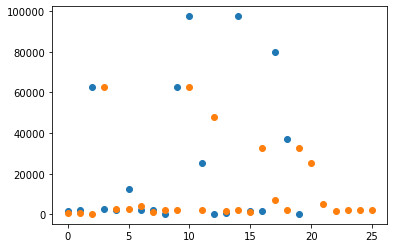

In [601]:
plt.scatter(ehf_df.index, ehf_df.exp)
plt.scatter(elf_df.index,elf_df.exp)

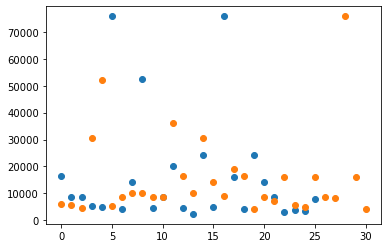

In [604]:
plt.scatter(thf_df.index, thf_df.exp)
plt.scatter(tlf_df.index,tlf_df.exp)

In [606]:
tlf_df

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,exp
0,2-CCTCCCC,STREME-2,34,56.0,62.0,-,12.83150,0.000036,0.236,CCTCCCC,5969.001247
1,2-CCTCCCC,STREME-2,36,69.0,75.0,-,12.83150,0.000036,0.236,CCTCCCC,5568.729357
2,2-CCTCCCC,STREME-2,42,180.0,186.0,-,12.83150,0.000036,0.236,CCTCCCC,4673.148344
3,2-CCTCCCC,STREME-2,6,173.0,179.0,-,11.35960,0.000080,0.392,TCTCCCC,30413.664815
4,1-AGTHTACCV,STREME-1,4,143.0,151.0,-,10.23810,0.000089,0.619,AGCCTACCG,52118.676687
5,1-AGTHTACCV,STREME-1,39,10.0,18.0,-,10.15480,0.000111,0.619,AGTATAGCA,5352.844331
6,2-CCTCCCC,STREME-2,Pnqo,198.0,204.0,+,10.44940,0.000124,0.448,CTTCCCC,8435.291500
7,1-AGTHTACCV,STREME-1,22,13.0,21.0,-,9.94048,0.000129,0.619,AGCCTACCA,10003.260302
8,1-AGTHTACCV,STREME-1,22,83.0,91.0,-,9.89286,0.000142,0.619,AGGCTACCA,10003.260302
9,5-GCCTCC,STREME-5,Pnqo,283.0,288.0,+,11.01020,0.000160,0.394,GCCTCC,8435.291500


In [607]:
thf_df

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,exp
0,4-CTCACCTCC,STREME-4,12,165.0,173.0,-,14.02040,0.000012,0.126,CTTACCTCC,16262.587914
1,4-CTCACCTCC,STREME-4,Pnqo,51.0,59.0,+,12.86730,0.000020,0.126,CTCACCCCC,8435.291500
2,6-AAGGAGGGAG,STREME-6,Pnqo,324.0,333.0,-,12.22940,0.000022,0.287,AAGGGGGGTG,8435.291500
3,1-AKTHTASCM,STREME-1,39,10.0,18.0,-,11.60710,0.000029,0.505,AGTATAGCA,5352.844331
4,4-CTCACCTCC,STREME-4,41,184.0,192.0,-,12.60200,0.000030,0.126,CACACCTCC,4760.126591
5,4-CTCACCTCC,STREME-4,PslpA,185.0,193.0,-,12.60200,0.000030,0.126,CACACCTCC,75856.516243
6,4-CTCACCTCC,STREME-4,44,167.0,175.0,+,12.53060,0.000032,0.126,TGCACCTCC,4333.645503
7,6-AAGGAGGGAG,STREME-6,18,55.0,64.0,+,10.53210,0.000048,0.287,AAGGGGTGTG,14350.127470
8,6-AAGGAGGGAG,STREME-6,3,115.0,124.0,-,10.05500,0.000057,0.287,AAGGAGTTAA,52424.329129
9,3-GAAAGGA,STREME-3,43,43.0,49.0,-,11.33330,0.000065,0.641,GAAAGGA,4420.983954


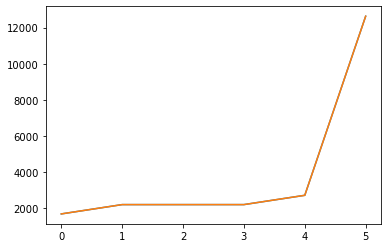

In [550]:
plt.plot(sorted(ehf_df.ecoli_exp))
plt.plot(sorted(elf_df.ecoli_exp))